In [2]:
#!pip install tqdm

In [3]:
#!pip install pandas

In [4]:
#!pip install nltk

In [5]:
#!pip install -U spacy

In [6]:
#!pip install es_core_news_sm

In [7]:
#!pip install scikit-learn

In [8]:
#!pip install matplotlib

In [9]:
#!pip install seaborn

In [10]:
#!pip install cltk

In [11]:
#!pip install scikit-plot

In [12]:
#!pip install imblearn

In [13]:
import os
os.chdir("/home/martinaleo/.ssh/authorship/pydro")

from src.dro import DistributionalRandomOversampling



In [14]:
# !ls /home/martinaleo/.ssh/authorship/pydro/src


# Imports

In [15]:
from tqdm.notebook import tqdm

from data_loader import load_spanish_corpus

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


import re

from nltk import download
from nltk import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
import spacy
import es_core_news_sm

from splitting__ import Segmentation

from helpers__ import get_function_words

from features import ( 
    FeaturesFunctionWords, 
    FeaturesDVEX, 
    FeaturesMendenhall, 
    FeaturesSentenceLength, 
    FeaturesPOST, 
    FeatureSetReductor,
    HstackFeatureSet
)

from sklearn.base import BaseEstimator, ClassifierMixin

from sklearn.feature_selection import SelectKBest, chi2

from sklearn.preprocessing import StandardScaler

from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold

from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    StratifiedKFold,
    RepeatedStratifiedKFold,
    RandomizedSearchCV,
    GridSearchCV,
)

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    RocCurveDisplay
)

from scikitplot.metrics import plot_roc

from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier

from imblearn.over_sampling import SMOTE


/home/martinaleo/.local/lib/python3.10/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'es_core_news_sm' (3.1.0) was trained with spaCy v3.1.0 and may not be 100% compatible with the current version (3.7.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
/home/martinaleo/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Loading

In [16]:
documents, authors, filenames = load_spanish_corpus(path='/home/martinaleo/authorship/src/data/Corpus')

loading: /home/martinaleo/authorship/src/data/Corpus: 100%|██████████| 31/31 [00:00<00:00, 1164.49it/s]


In [17]:
print(filenames)

['Agustín de Rojas Villandrando - El viaje entretenido', 'Alonso de Castillo Solórzano - Aventuras del Bachiller Trapaza', 'Alonso de Castillo Solórzano - Las harpías en Madrid y coche de las estafas', 'Avellaneda - Quijote apocrifo', 'Cervantes - El amante liberal', 'Cervantes - El casamiento engañoso', 'Cervantes - El celoso extremeño', 'Cervantes - El coloquio de los perros', 'Cervantes - El licenciado Vidriera', 'Cervantes - La Gitanilla', 'Cervantes - La dos doncellas', 'Cervantes - La española inglesa', 'Cervantes - La fuerza de la sangre', 'Cervantes - La ilustre fregona', 'Cervantes - La señora Cornelia', 'Cervantes - Los trabajos de Persiles y Sigismunda', 'Cervantes - Rinconete y Cortadillo', 'Cristóbal Suárez de Figueroa - El pasajero', 'Guillén de Castro - El nacimiento de Montesinos', 'Guillén de Castro - Las mocedades del Cid', 'Juan Ruiz de Alarcón y Mendoza - La verdad sospechosa', 'Lope de Vega - Guzmán el Bravo', 'Lope de Vega - La desdicha por la honra', 'Lope de Veg

In [18]:
np.unique(authors, return_counts=True)

(array(['Agustín de Rojas Villandrando ', 'Alonso de Castillo Solórzano ',
        'Avellaneda ', 'Cervantes ', 'Cristóbal Suárez de Figueroa ',
        'Guillén de Castro ', 'Juan Ruiz de Alarcón y Mendoza ',
        'Lope de Vega ', 'Mateo Alemán ', 'Pasamonte ', 'Pérez de Hita ',
        'Quevedo ', 'Tirso de Molina '], dtype='<U31'),
 array([ 1,  2,  1, 13,  1,  2,  1,  4,  2,  1,  1,  1,  1]))

# Data Cleaning

### Noise elimination

In [19]:
documents = documents[:3] + documents[4:]
authors= authors[:3] + authors[4:]
filenames= filenames[:3] + filenames[4:]

In [20]:
for i in np.unique(authors, return_counts=True)[1]:
    print(i)
    break

1


In [21]:
auth_to_loop= [author.strip() for author, n_docs in zip(np.unique(authors, return_counts=True)[0], np.unique(authors, return_counts=True)[1]) if n_docs>1]
auth_to_loop

['Alonso de Castillo Solórzano',
 'Cervantes',
 'Guillén de Castro',
 'Lope de Vega',
 'Mateo Alemán']

In [22]:
documents = [document.lower() for document in documents]
documents = [(re.sub(r'\[(?:(?!\[|\]).)*\]', '', document)) for document in documents] 
# elimina le parti di testo delimitate da [] e che non contengono al loro interno ][

authors = [author.rstrip() for author in authors]

# Segmentation & Splitting

In [23]:
target = auth_to_loop[1]
y_labels =  (target, 'Other')

In [24]:
X = documents
y = [1 if author.rstrip() == target else 0 for author in authors]
# y_cat = [1 if author.rstrip() == target else 0 for author in authors]

positive_class = np.sum(y)
negative_class = len(y) - positive_class

print('Target class:', target)
print(f'Positive samples: {positive_class}')
print(f'Negative samples: {negative_class}')

Target class: Cervantes
Positive samples: 13
Negative samples: 17


In [25]:
def compute_n_tokens(filenames, documents):
    tokens_per_doc = sorted([(opus, sum(len(word_tokenize(sent)) for sent in sent_tokenize(doc))) for opus, doc in zip(filenames, documents)], key=lambda x: x[1], reverse=True)
    mean_tok = round(np.mean([n_tok for opus, n_tok in tokens_per_doc]), 2)
    median_tok = round(np.median([n_tok for opus, n_tok in tokens_per_doc]), 2)
    std_tok =  round(np.std([n_tok for opus, n_tok in tokens_per_doc]), 2)
    return tokens_per_doc, mean_tok, median_tok, std_tok

In [26]:
# tokens_per_doc,_,_,_ = compute_n_tokens([filename.split('-')[1].strip() for filename in filenames], documents)
# tokens_per_doc

In [27]:
# df_tok = pd.DataFrame(tokens_per_doc, columns=['Opus', 'Num of tokens'])

# plt.figure(figsize=(10, 6)) 
# sns.barplot(x='Opus', y='Num of tokens', data=df_tok, hue='Opus', dodge=False)  
# plt.xticks(rotation=60, ha="right")  
# plt.show()

In [28]:
# from nltk.tokenize import sent_tokenize

# sent_lenghts = [[len(word_tokenize(sent)) for sent in sent_tokenize(text)] for text in documents]

In [29]:
# mean_per_doc = 0
# mean_len_dict = dict()

# for i, sent_len_set in enumerate(sent_lenghts):
#     for sent_len in sent_len_set:
#         mean_per_doc +=sent_len
#     mean_per_doc = mean_per_doc/len(sent_len_set)
#     mean_len_dict[i+1]=mean_per_doc

In [30]:
# flat_lenghts = list()
# for row in sent_lenghts:
#     flat_lenghts.extend(row)
# [len_s for len_s in flat_lenghts if len_s > 300]

In [31]:
# plt.hist(flat_lenghts, bins=range(min(flat_lenghts), max(flat_lenghts) + 2), align='left', color='blue')
# plt.axvline(np.mean(flat_lenghts), color='red', linestyle='dashed', linewidth=1, label=f'Media = {round(np.mean(flat_lenghts),2)}')
# plt.axvline(np.median(flat_lenghts), color='black', linestyle='dashed', linewidth=1, label=f'Mediana = {round(np.median(flat_lenghts),2)}')
# plt.axvline(np.percentile(flat_lenghts,10), color='green', linestyle='dashed', linewidth=1.5, label=f'10th percentile = {round(np.percentile(flat_lenghts,10),2)}')
# plt.legend()
# plt.show()

In [32]:
X_dev, X_test, y_dev, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

In [33]:
positive_class_dev = np.sum(y_dev)
negative_class_dev = len(y_dev) - positive_class_dev
pos_ratio_dev = round(positive_class_dev / len(y_dev), 2)

positive_class_test = np.sum(y_test)
negative_class_test = len(y_test) - positive_class_test
pos_ratio_test = round(positive_class_test / len(y_test), 2)

tot_pos_ratio = (positive_class_dev + positive_class_test) / len(y)

print(f'Positive samples: {positive_class_dev}')
print(f'Negative samples: {negative_class_dev}')
print()
print(f'Positive samples: {positive_class_test}')
print(f'Negative samples: {negative_class_test}')

Positive samples: 9
Negative samples: 12

Positive samples: 4
Negative samples: 5


In [34]:
print('Positive samples ratio:', 
    '\nTrain:', pos_ratio_dev, 
    '\nTest:', pos_ratio_test, 
    '\nWhole dataset:',tot_pos_ratio)

Positive samples ratio: 
Train: 0.43 
Test: 0.44 
Whole dataset: 0.43333333333333335


In [35]:
min_tokens = 500

segmentator_dev = Segmentation(split_policy='by_sentence', tokens_per_fragment=min_tokens)
splitted_docs_dev = segmentator_dev.fit_transform(documents=X_dev, authors=y_dev)
groups_dev = segmentator_dev.groups
# lista composta da due liste, una contenente le frasi, una contenente gli autori

generating fragments:   0%|          | 0/21 [00:00<?, ?it/s]

generating fragments: 100%|██████████| 21/21 [01:07<00:00,  3.21s/it]


In [36]:
len(groups_dev) # la segmentazione restituisce sia i documenti per intero che quelli frammentati

2162

In [37]:
segmentator_test = Segmentation(split_policy='by_sentence', tokens_per_fragment=min_tokens)
splitted_docs_test = segmentator_test.transform(documents=X_test, authors=y_test)
groups_test = segmentator_test.groups

generating fragments:   0%|          | 0/9 [00:00<?, ?it/s]

generating fragments: 100%|██████████| 9/9 [00:24<00:00,  2.76s/it]


In [38]:
# set per interi documenti
whole_docs_test = splitted_docs_test[0][:10]
whole_docs_y_test = splitted_docs_test[1][:10]
whole_docs_groups_test = groups_test[:10]

# set per documenti frammentati
fragmented_docs_test = splitted_docs_test[0][10:]
fragmented_docs_y_test = splitted_docs_test[1][10:]
fragmented_docs_groups_test = groups_test[10:]

In [39]:
print((len(splitted_docs_dev[0]), len(splitted_docs_dev[1]), len(groups_dev)),
(len(splitted_docs_test[0]), len(splitted_docs_test[1]), len(groups_test)))

(2162, 2162, 2162) (665, 665, 665)


In [40]:
np.unique(splitted_docs_dev[1], return_counts=True), np.unique(splitted_docs_test[1], return_counts=True)

((array([0, 1]), array([1570,  592])), (array([0, 1]), array([541, 124])))

In [41]:
dev_pos_class_ratio = np.sum(splitted_docs_dev[1]) / len(splitted_docs_dev[1])
test_pos_class_ratio = np.sum(splitted_docs_test[1]) / len(splitted_docs_test[1])
tot_pos_class_ratio = (np.sum(splitted_docs_dev[1]) + np.sum(splitted_docs_test[1])) / (len(splitted_docs_dev[1]) + len(splitted_docs_test[1]))

In [42]:
print('Positive samples ratio:', 
      '\nTrain:', dev_pos_class_ratio, 
      '\nTest:', test_pos_class_ratio,
      '\nWhole dataset:', tot_pos_class_ratio)

Positive samples ratio: 
Train: 0.2738205365402405 
Test: 0.18646616541353384 
Whole dataset: 0.2532720198089848


In [43]:
X_dev = splitted_docs_dev[0]
y_dev = splitted_docs_dev[1]
groups_dev = segmentator_dev.groups

X_test = whole_docs_test
y_test = whole_docs_y_test
groups_test = whole_docs_groups_test

X_test_frag = fragmented_docs_test
y_test_frag = fragmented_docs_y_test
groups_test_frag = fragmented_docs_groups_test
#y__ = list(zip(splitted_docs[1], groups))

len(X_dev), len(y_dev), len(groups_dev),len(X_test), len(y_test), len(groups_test)

(2162, 2162, 2162, 10, 10, 10)

In [44]:
def get_group_names(groups):
    groups_names = [filenames[doc_idx] for doc_idx in groups]
    groups_names_distribution = {name:round((np.unique(groups_names, return_counts=True)[1][i])/len(groups_names),2) 
                                 for i, name in enumerate(np.unique(groups_names))}
    return groups_names, groups_names_distribution

goups_names_dev, groups_names_distribution_dev =get_group_names(groups_dev)
goups_names_test, groups_names_distribution_test =get_group_names(groups_test)
goups_names_test_frag, groups_names_distribution_test_frag = get_group_names(groups_test_frag)
groups_names_distribution_dev
    

{'Agustín de Rojas Villandrando - El viaje entretenido': 0.02,
 'Alonso de Castillo Solórzano - Aventuras del Bachiller Trapaza': 0.07,
 'Alonso de Castillo Solórzano - Las harpías en Madrid y coche de las estafas': 0.13,
 'Cervantes - El amante liberal': 0.1,
 'Cervantes - El casamiento engañoso': 0.11,
 'Cervantes - El celoso extremeño': 0.05,
 'Cervantes - El coloquio de los perros': 0.11,
 'Cervantes - El licenciado Vidriera': 0.02,
 'Cervantes - La Gitanilla': 0.04,
 'Cervantes - La dos doncellas': 0.05,
 'Cervantes - La española inglesa': 0.01,
 'Cervantes - La fuerza de la sangre': 0.14,
 'Cervantes - La ilustre fregona': 0.02,
 'Cervantes - La señora Cornelia': 0.02,
 'Cervantes - Los trabajos de Persiles y Sigismunda': 0.01,
 'Cervantes - Rinconete y Cortadillo': 0.01,
 'Cristóbal Suárez de Figueroa - El pasajero': 0.01,
 'Guillén de Castro - El nacimiento de Montesinos': 0.02,
 'Guillén de Castro - Las mocedades del Cid': 0.01,
 'Juan Ruiz de Alarcón y Mendoza - La verdad sos

# Data Preparation

In [45]:
fuction_ws = get_function_words(lang='spanish')

In [46]:
# vectorizers
function_words_extractor = FeaturesFunctionWords(language='spanish')
mendenhall_extractor = FeaturesMendenhall(upto=20)
words_masker = FeaturesDVEX(function_words=fuction_ws)
sentence_len_extractor = FeaturesSentenceLength()
POS_extractor = FeaturesPOST(language='spanish')

loading cache from .postcache/dict.pkl


In [50]:
vectorizers = [function_words_extractor, mendenhall_extractor, words_masker, sentence_len_extractor, POS_extractor]

In [48]:
# from sklearn.preprocessing import Normalizer # new!

# def l2_normalize(features, features_test):
#     normalizer = Normalizer()
#     features_norm = normalizer.fit_transform(features)
#     features_norm_test = normalizer.transform(features_test)
#     return features_norm, features_norm_test

In [49]:
# fw_norm, fw_norm_test = l2_normalize(fw_red, fw_red_test)
# me_norm, me_norm_test = l2_normalize(me_red, me_red_test)
# wm_norm, wm_norm_test = l2_normalize(wm_red, wm_red_test)
# pos_norm, pos_norm_test = l2_normalize(pos_red, pos_red_test)

# Support classes and functions

In [70]:
class StandardizedCalibratedClassifierCV(CalibratedClassifierCV):
    def __init__(self, base_estimator=None, method='sigmoid', cv=None, normalize=True):
        super().__init__(base_estimator=base_estimator, method=method, cv=cv)
        self.normalize=normalize
    
    def predict_proba(self, X):
        proba_output = super().predict_proba(X)
        if self.normalize:
            scaler = StandardScaler()
            proba_output = scaler.fit_transform(proba_output)
        return proba_output

In [78]:
class FunTAT_StackingClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, vectorizers, C_lr=1, C_svm=1, kernel_svm='rbf', gamma_svm='scale', degree_svm=3, normalize=False):
        self.vectorizers = vectorizers

        self.C_lr = C_lr
        
        self.C_svm = C_svm
        self.kernel_svm = kernel_svm
        self.gamma_svm=gamma_svm
        self.degree_svm= degree_svm

        self.normalize=normalize
        
    def fit(self, X, y):

        base_clfs = [LinearSVC(random_state=42, class_weight='balanced', max_iter=1000000, dual='auto', C=self.C_lr) for i in np.arange(len(vectorizers))]

        systems = [Pipeline([
        ('feat_extractor', vectorizer),
        ('classifier', StandardizedCalibratedClassifierCV(base_clf, normalize=self.normalize))
        ]) 
        for vectorizer, base_clf in zip(self.vectorizers, base_clfs)]

        estimators = [(f'model_{i+1}', system) for i,system in enumerate(systems)]

        for name, system in estimators:
            system.fit(X, y)

        stack = StackingClassifier(
            estimators=estimators,
            final_estimator=SVC(C=self.C_svm, kernel=self.kernel_svm, gamma=self.gamma_svm, degree=self.degree_svm),
            cv=3,
            stack_method='predict_proba',
            n_jobs=1,
            verbose=True
        ).fit(X, y)

        self.stack = stack

        return self
    
    def predict(self, X):
        return self.stack.predict(X)

In [52]:
def find_mismatched_docs(y_test, y_pred, group_names_test, groups_names_distribution, plot_res=True):
    res_df = pd.DataFrame(columns=['Mismatched_doc', 'Distribution_over_total_errors', 'Distribution_over_test_set'])
    wrong_indices = np.where(y_test != y_pred)[0]
    mismatched_docs = [group_names_test[idx] for idx in wrong_indices]
    distribution = {name:round((np.unique(mismatched_docs, return_counts=True)[1][i])/len(mismatched_docs),2) 
                                 for i, name in enumerate(np.unique(mismatched_docs))}

    for i, (key, val) in enumerate(distribution.items()):    
        res_df.loc[i]={
            'Mismatched_doc':  key,
            'Distribution_over_total_errors': val,
            'Distribution_over_test_set':groups_names_distribution[key] 
        }

    if plot_res:
        positions = np.arange(len(res_df))
        plt.bar(positions, res_df['Distribution_over_total_errors'], 0.35, label='Distribution_over_total_errors')
        plt.bar(positions + 0.35, res_df['Distribution_over_test_set'], 0.35, label='Distribution_over_test_set')

        plt.xlabel('Mismatched docs')
        plt.ylabel('Relative distribution')
        plt.title('Comparing distribution of docs over errors and test set')
        plt.xticks(positions + 0.35 / 2, res_df['Mismatched_doc'].apply(lambda x: x.split(' - ')[1]))
        plt.xticks(rotation=90)
        plt.legend()

        plt.show()
    return mismatched_docs, distribution, res_df.sort_values(by='Distribution_over_total_errors', ascending=False)

In [53]:
def get_scores(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    print('Accuracy on whole docs', acc)
    print('F1 on whole docs', f1)
    print()
    print(classification_report(y_test, y_pred))
    return y_pred

In [54]:
def plot_res(y_test, y_pred):
    plt.subplots(figsize=(8,6))
    cf = confusion_matrix(y_test, y_pred, normalize='true')
    sns.heatmap(cf, annot=True, fmt='.2f', cmap="Blues", xticklabels=y_labels, yticklabels=y_labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    df_res = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    sns.countplot(x="variable", hue="value", data=pd.melt(df_res))
    plt.title('Actual distribution vs predicted', fontsize=14)

    plt.legend(loc='best', bbox_to_anchor=(1, 0.9), fancybox=True, shadow=True)
    plt.show()

# Stacking Classifier

## Fun KFCV

In [56]:
%%time
base_clfs = [LinearSVC(random_state=42, class_weight='balanced', max_iter=10000, dual='auto') for i in range(5)]
final_estimator = SVC(class_weight='balanced', random_state=42)
svm = CalibratedClassifierCV(LinearSVC())


systems = [Pipeline([
    ('feat_extractor', vectorizer),
    ('classifier', CalibratedClassifierCV(base_clf))
    ]) 
    for vectorizer, base_clf in zip(vectorizers, base_clfs)]

estimators = [(f'model_{i+1}', system) for i,system in enumerate(systems)]

param_grid = {'model_1__classifier__estimator__C': [10]}

stack = StackingClassifier(
    estimators = estimators,
    final_estimator = final_estimator,
    cv=5,
    stack_method='predict_proba',
    n_jobs=5,
)
grid = GridSearchCV(estimator=stack,
                    param_grid=param_grid,
                    cv=5,
                    scoring='f1_weighted',
                    n_jobs=5)

grid.fit(X_dev, y_dev, groups=groups_dev)

/home/martinaleo/.local/lib/python3.10/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'es_core_news_sm' (3.1.0) was trained with spaCy v3.1.0 and may not be 100% compatible with the current version (3.7.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
/home/martinaleo/.local/lib/python3.10/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'es_core_news_sm' (3.1.0) was trained with spaCy v3.1.0 and may not be 100% compatible with the current version (3.7.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
/home/martinaleo/.local/lib/python3.10/site-packages/spacy/util.py:910: UserWarning: [W095] Mo

CPU times: user 55 s, sys: 2.19 s, total: 57.1 s
Wall time: 11min 41s


GridSearchCV(cv=5,
             estimator=StackingClassifier(cv=5,
                                          estimators=[('model_1',
                                                       Pipeline(steps=[('feat_extractor',
                                                                        <features.FeaturesFunctionWords object at 0x7f6bf7b8f220>),
                                                                       ('classifier',
                                                                        CalibratedClassifierCV(estimator=LinearSVC(class_weight='balanced',
                                                                                                                   dual='auto',
                                                                                                                   max_iter=10000,
                                                                                                                   random_state=42)))])),
                                                      ('model_2',
                                                       Pipeline(steps=[('feat_extractor',
                                                                        <features....
                                                                        <features.FeaturesPOST object at 0x7f6b4419ea40>),
                                                                       ('classifier',
                                                                        CalibratedClassifierCV(estimator=LinearSVC(class_weight='balanced',
                                                                                                                   dual='auto',
                                                                                                                   max_iter=10000,
                                                                                                                   random_state=42)))]))],
                                          final_estimator=SVC(class_weight='balanced',
                                                              random_state=42),
                                          n_jobs=5,
                                          stack_method='predict_proba'),
             n_jobs=5, param_grid={'model_1__classifier__estimator__C': [10]},
             scoring='f1_weighted')

In [62]:
print(grid.best_estimator_)

StackingClassifier(cv=5,
                   estimators=[('model_1',
                                Pipeline(steps=[('feat_extractor',
                                                 <features.FeaturesFunctionWords object at 0x7f6b34312a10>),
                                                ('classifier',
                                                 CalibratedClassifierCV(estimator=LinearSVC(C=10,
                                                                                            class_weight='balanced',
                                                                                            dual='auto',
                                                                                            max_iter=10000,
                                                                                            random_state=42)))])),
                               ('model_2',
                                Pipeline(steps=[('feat_extractor',
                                        

In [63]:
clf= grid.best_estimator_
y_pred = get_scores(clf, X_test, y_test)


Accuracy on whole docs 1.0
F1 on whole docs 1.0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



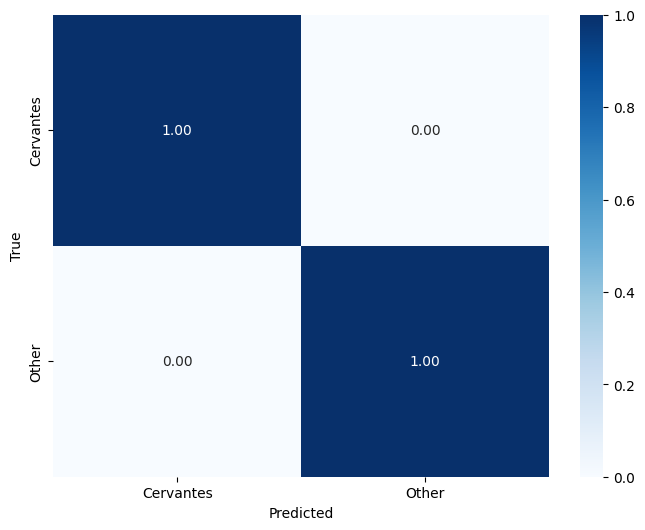

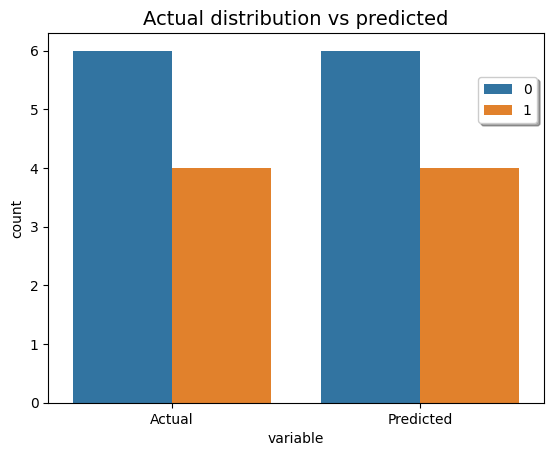

In [64]:
plot_res(y_test, y_pred)

In [65]:
y_pred_frag = get_scores(clf, X_test_frag, y_test_frag)

Accuracy on whole docs 0.9068702290076336
F1 on whole docs 0.9054444130320153

              precision    recall  f1-score   support

           0       0.94      0.95      0.94       535
           1       0.77      0.71      0.74       120

    accuracy                           0.91       655
   macro avg       0.85      0.83      0.84       655
weighted avg       0.90      0.91      0.91       655



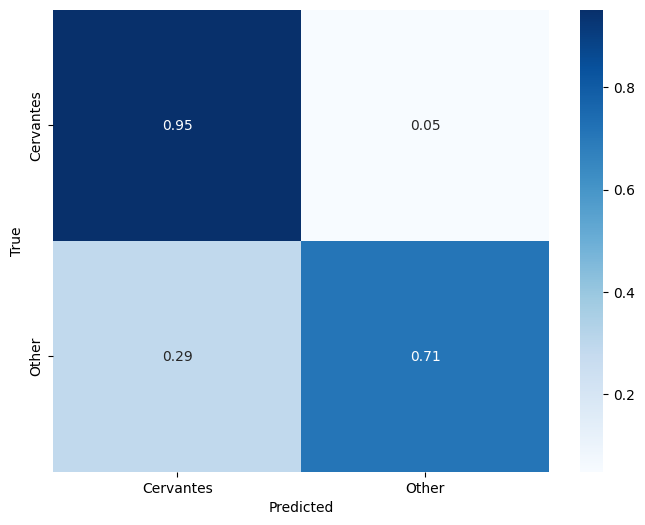

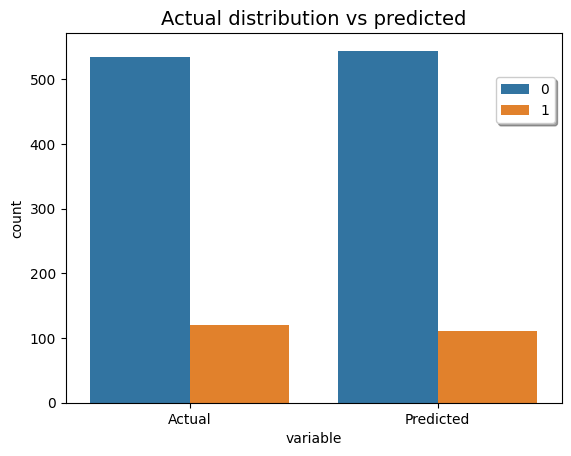

In [66]:
plot_res(y_test_frag, y_pred_frag)

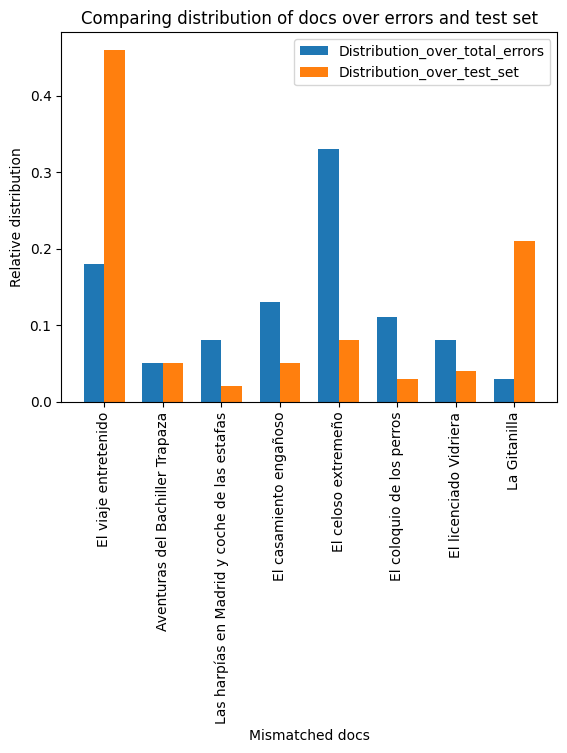

,Mismatched_doc,Distribution_over_total_errors,Distribution_over_test_set
4,Cervantes - El celoso extremeño,0.33,0.08
0,Agustín de Rojas Villandrando - El viaje entre...,0.18,0.46
3,Cervantes - El casamiento engañoso,0.13,0.05
5,Cervantes - El coloquio de los perros,0.11,0.03
2,Alonso de Castillo Solórzano - Las harpías en ...,0.08,0.02
6,Cervantes - El licenciado Vidriera,0.08,0.04
1,Alonso de Castillo Solórzano - Aventuras del B...,0.05,0.05
7,Cervantes - La Gitanilla,0.03,0.21


In [67]:
mismatched_docs, mismatched_docs_distribution, res_df = find_mismatched_docs(y_test_frag,
                                                                              y_pred_frag, 
                                                                              goups_names_test_frag, 
                                                                              groups_names_distribution_test_frag)
res_df

## Fun TAT with grid search

### Without normalization

In [79]:
%%time
grid = RandomizedSearchCV(
    estimator=FunTAT_StackingClassifier(vectorizers=vectorizers, normalize=False),
    param_distributions={
        'C_lr': np.logspace(-1,1,3),
        'C_svm': np.logspace(-1,1,3),
        'kernel_svm': ['rbf', 'poly'],
        'gamma_svm': [0.0001, 0.001, 0.1, 1, 'scale', 'auto'],
        'degree_svm': [2, 3, 4],
    },
    n_jobs=1,
    scoring='f1_weighted',
    n_iter=1,
    cv=3,
    random_state=42,
    verbose=True
)

grid.fit(X_dev, y_dev, groups=groups_dev)
print(grid.best_params_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/martinaleo/.local/lib/python3.10/site-packages/sklearn/calibration.py:300: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/martinaleo/.local/lib/python3.10/site-packages/sklearn/calibration.py:300: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/martinaleo/.local/lib/python3.10/site-packages/sklearn/calibration.py:300: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/martinaleo/.local/lib/python3.10/site-packages/sklearn/calibration.py:300: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/martinaleo/.local/lib/python3.10/site-packages/sklearn/calibration.py:300: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


{'kernel_svm': 'rbf', 'gamma_svm': 1, 'degree_svm': 4, 'C_svm': 10.0, 'C_lr': 0.1}
CPU times: user 25min 41s, sys: 1min 18s, total: 26min 59s
Wall time: 25min 17s


In [80]:
grid.best_estimator_

FunTAT_StackingClassifier(C_lr=0.1, C_svm=10.0, degree_svm=4, gamma_svm=1,
                          vectorizers=[<features.FeaturesFunctionWords object at 0x7f6ab6661720>,
                                       <features.FeaturesMendenhall object at 0x7f6ab66611e0>,
                                       <features.FeaturesDVEX object at 0x7f6ab6662740>,
                                       <features.FeaturesSentenceLength object at 0x7f6ab6663610>,
                                       <features.FeaturesPOST object at 0x7f6ab6663f70>])

In [81]:
clf = grid.best_estimator_
y_pred = get_scores(clf, X_test, y_test)

Accuracy on whole docs 0.9
F1 on whole docs 0.8967032967032967

              precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       1.00      0.75      0.86         4

    accuracy                           0.90        10
   macro avg       0.93      0.88      0.89        10
weighted avg       0.91      0.90      0.90        10



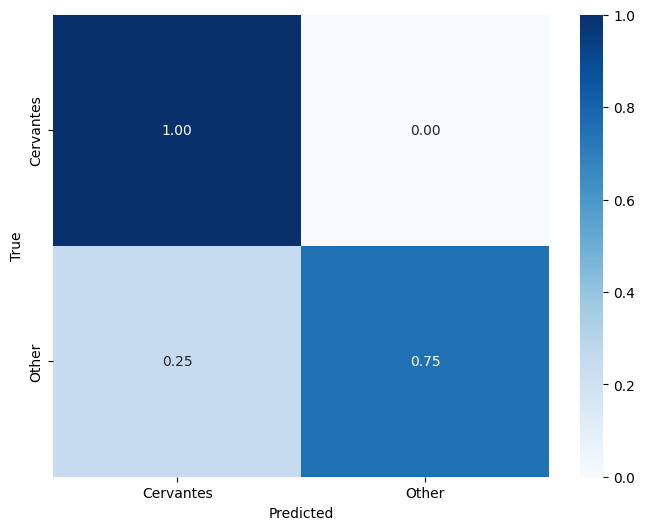

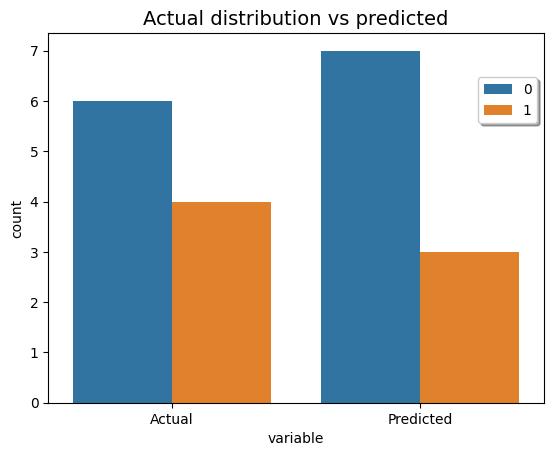

In [82]:
plot_res(y_test, y_pred)

In [83]:
y_pred_frag = get_scores(clf, X_test_frag, y_test_frag)

Accuracy on whole docs 0.8687022900763359
F1 on whole docs 0.8457014786629798

              precision    recall  f1-score   support

           0       0.87      0.99      0.92       535
           1       0.84      0.35      0.49       120

    accuracy                           0.87       655
   macro avg       0.86      0.67      0.71       655
weighted avg       0.87      0.87      0.85       655



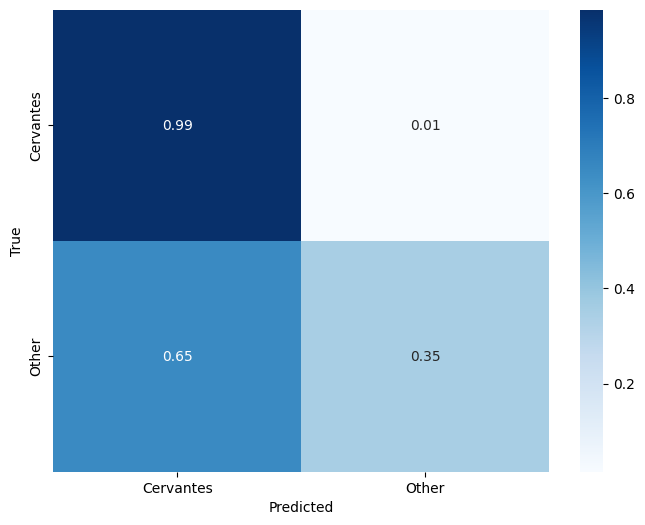

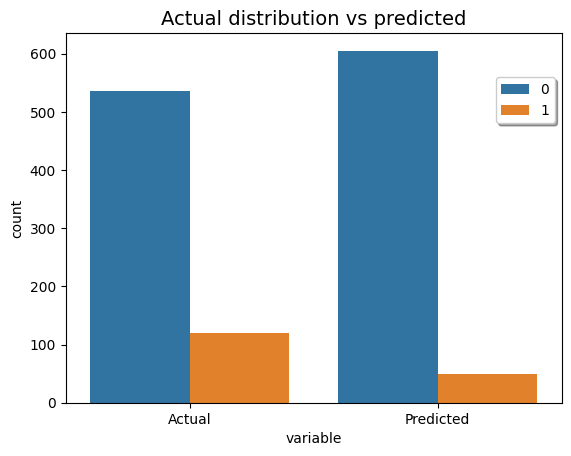

In [84]:
plot_res(y_test_frag, y_pred_frag)

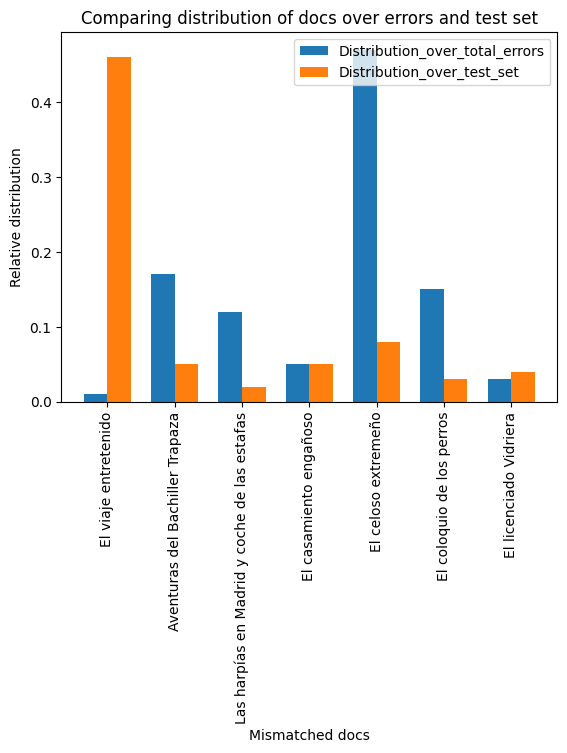

,Mismatched_doc,Distribution_over_total_errors,Distribution_over_test_set
4,Cervantes - El celoso extremeño,0.47,0.08
1,Alonso de Castillo Solórzano - Aventuras del B...,0.17,0.05
5,Cervantes - El coloquio de los perros,0.15,0.03
2,Alonso de Castillo Solórzano - Las harpías en ...,0.12,0.02
3,Cervantes - El casamiento engañoso,0.05,0.05
6,Cervantes - El licenciado Vidriera,0.03,0.04
0,Agustín de Rojas Villandrando - El viaje entre...,0.01,0.46


In [85]:
mismatched_docs, mismatched_docs_distribution, res_df = find_mismatched_docs(y_test_frag,
                                                                              y_pred_frag, 
                                                                              goups_names_test_frag, 
                                                                              groups_names_distribution_test_frag)
res_df

### With normalization

In [86]:
%%time
grid = RandomizedSearchCV(
    estimator=FunTAT_StackingClassifier(vectorizers=vectorizers, normalize=True),
    param_distributions={
        'C_lr': np.logspace(-1,1,3),
        'C_svm': np.logspace(-1,1,3),
        'kernel_svm': ['rbf', 'poly'],
        'gamma_svm': [0.0001, 0.001, 0.1, 1, 'scale', 'auto'],
        'degree_svm': [2, 3, 4],
    },
    n_jobs=1,
    scoring='f1_weighted',
    n_iter=1,
    cv=3,
    random_state=42,
    verbose=True
)

grid.fit(X_dev, y_dev, groups=groups_dev)
print(grid.best_params_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/martinaleo/.local/lib/python3.10/site-packages/sklearn/calibration.py:300: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/martinaleo/.local/lib/python3.10/site-packages/sklearn/calibration.py:300: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/martinaleo/.local/lib/python3.10/site-packages/sklearn/calibration.py:300: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/martinaleo/.local/lib/python3.10/site-packages/sklearn/calibration.py:300: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/martinaleo/.local/lib/python3.10/site-packages/sklearn/calibration.py:300: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


{'kernel_svm': 'rbf', 'gamma_svm': 1, 'degree_svm': 4, 'C_svm': 10.0, 'C_lr': 0.1}
CPU times: user 25min 41s, sys: 1min 17s, total: 26min 59s
Wall time: 25min 17s


In [87]:
clf= grid.best_estimator_

In [88]:
y_pred = get_scores(clf, X_test, y_test)

Accuracy on whole docs 0.9
F1 on whole docs 0.901010101010101

              precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.80      1.00      0.89         4

    accuracy                           0.90        10
   macro avg       0.90      0.92      0.90        10
weighted avg       0.92      0.90      0.90        10



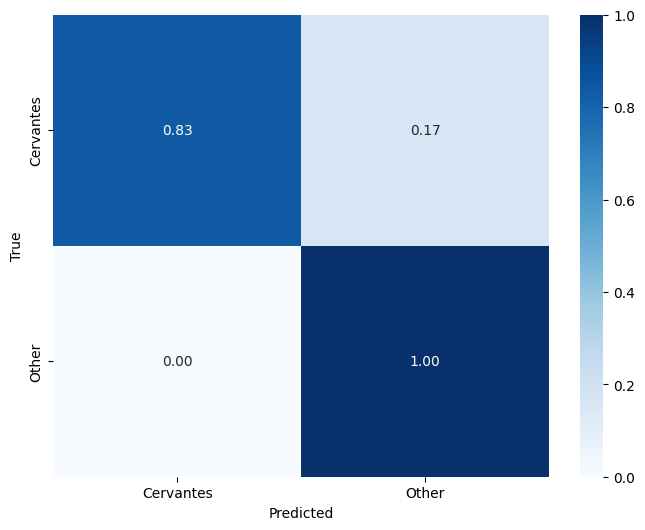

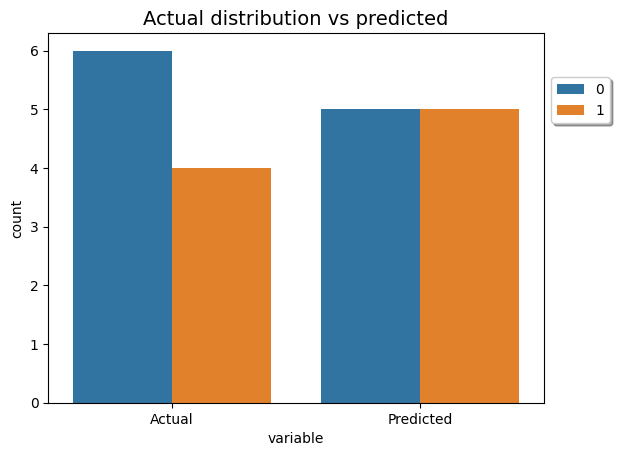

In [89]:
plot_res(y_test, y_pred)

In [90]:
y_pred_frag = get_scores(clf, X_test_frag, y_test_frag)

Accuracy on whole docs 0.8305343511450382
F1 on whole docs 0.8347712898162893

              precision    recall  f1-score   support

           0       0.91      0.88      0.89       535
           1       0.53      0.61      0.57       120

    accuracy                           0.83       655
   macro avg       0.72      0.74      0.73       655
weighted avg       0.84      0.83      0.83       655



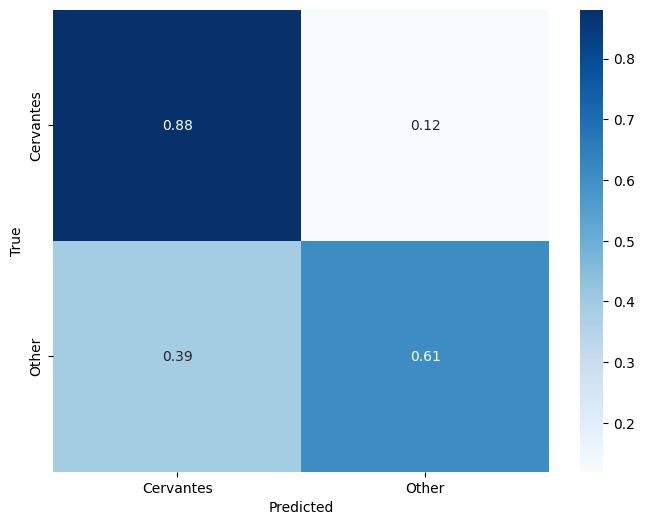

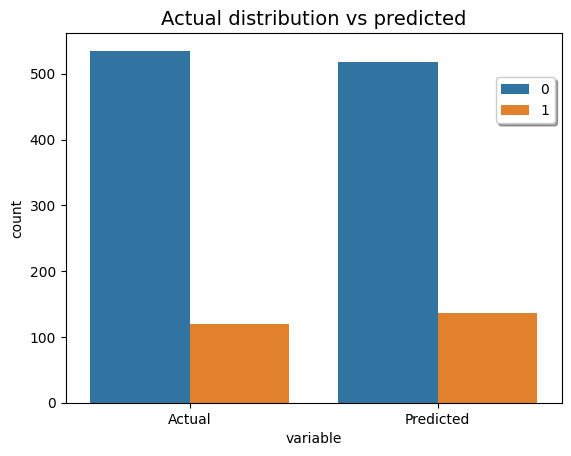

In [91]:
plot_res(y_test_frag, y_pred_frag)

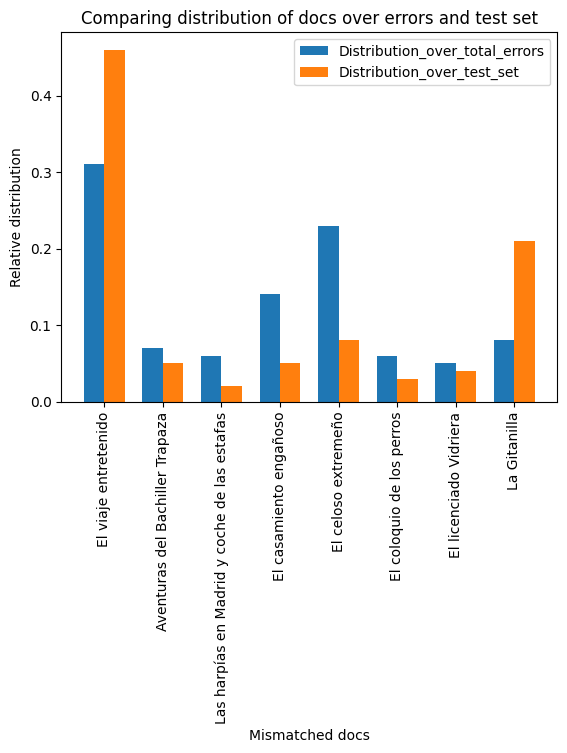

,Mismatched_doc,Distribution_over_total_errors,Distribution_over_test_set
0,Agustín de Rojas Villandrando - El viaje entre...,0.31,0.46
4,Cervantes - El celoso extremeño,0.23,0.08
3,Cervantes - El casamiento engañoso,0.14,0.05
7,Cervantes - La Gitanilla,0.08,0.21
1,Alonso de Castillo Solórzano - Aventuras del B...,0.07,0.05
2,Alonso de Castillo Solórzano - Las harpías en ...,0.06,0.02
5,Cervantes - El coloquio de los perros,0.06,0.03
6,Cervantes - El licenciado Vidriera,0.05,0.04


In [92]:
mismatched_docs, mismatched_docs_distribution, res_df = find_mismatched_docs(y_test_frag,
                                                                              y_pred_frag, 
                                                                              goups_names_test_frag, 
                                                                              groups_names_distribution_test_frag)
res_df

## Fun KFCV with grid search

###  Without normalization

In [95]:
base_clfs = [LinearSVC(random_state=42, class_weight='balanced', max_iter=100000, dual='auto') for i in range(5)]
final_estimator = SVC(class_weight='balanced', random_state=42)
#svm = CalibratedClassifierCV(LinearSVC())


systems = [Pipeline([
    ('feat_extractor', vectorizer),
    ('classifier', CalibratedClassifierCV(base_clf))
    ]) 
    for vectorizer, base_clf in zip(vectorizers, base_clfs)]

estimators = [(f'model{i+1}', system) for i,system in enumerate(systems)]

stack = StackingClassifier(
    estimators = estimators,
    final_estimator = final_estimator,
    cv=5,
    stack_method='predict_proba',
    n_jobs=5,
)

param_grid = {'model1__classifier__estimator__C': [10]}


param_grid_ = [
   {
    'kernel': ['rbf',],
    'C' : [0.01, 0.1, 1, 10, 100],
    'gamma' : [0.001, 0.1, 1, 'scale', 'auto'],
},
{
    'kernel' : ['poly'],
    'C' : [0.01, 0.1, 1, 10, 100],
    'gamma' : [0.001, 0.1, 1, 'scale', 'auto'],
    'degree': [1, 2, 3, 4, 5]
}]


grid = GridSearchCV(estimator=stack, param_grid=param_grid, cv=3, n_jobs=3, scoring='f1_weighted', verbose=True)
grid.fit(X_dev, y_dev, groups=groups_dev)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/martinaleo/.local/lib/python3.10/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'es_core_news_sm' (3.1.0) was trained with spaCy v3.1.0 and may not be 100% compatible with the current version (3.7.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
/home/martinaleo/.local/lib/python3.10/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'es_core_news_sm' (3.1.0) was trained with spaCy v3.1.0 and may not be 100% compatible with the current version (3.7.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
/home/martinaleo/.local/lib/python3.10/site-packages/spacy/util.py:910: UserWarning: [W095] Mo

GridSearchCV(cv=3,
             estimator=StackingClassifier(cv=5,
                                          estimators=[('model1',
                                                       Pipeline(steps=[('feat_extractor',
                                                                        <features.FeaturesFunctionWords object at 0x7f6bf7b8f220>),
                                                                       ('classifier',
                                                                        CalibratedClassifierCV(estimator=LinearSVC(class_weight='balanced',
                                                                                                                   dual='auto',
                                                                                                                   max_iter=10000,
                                                                                                                   random_state=42)))])),
                                                      ('model2',
                                                       Pipeline(steps=[('feat_extractor',
                                                                        <features.Fe...
                                                                        <features.FeaturesPOST object at 0x7f6b4419ea40>),
                                                                       ('classifier',
                                                                        CalibratedClassifierCV(estimator=LinearSVC(class_weight='balanced',
                                                                                                                   dual='auto',
                                                                                                                   max_iter=10000,
                                                                                                                   random_state=42)))]))],
                                          final_estimator=SVC(class_weight='balanced',
                                                              random_state=42),
                                          n_jobs=5,
                                          stack_method='predict_proba'),
             n_jobs=3, param_grid={'model1__classifier__estimator__C': [10]},
             scoring='f1_weighted', verbose=True)

In [96]:
clf=grid.best_estimator_
y_pred = get_scores(clf, X_test, y_test)

Accuracy on whole docs 1.0
F1 on whole docs 1.0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



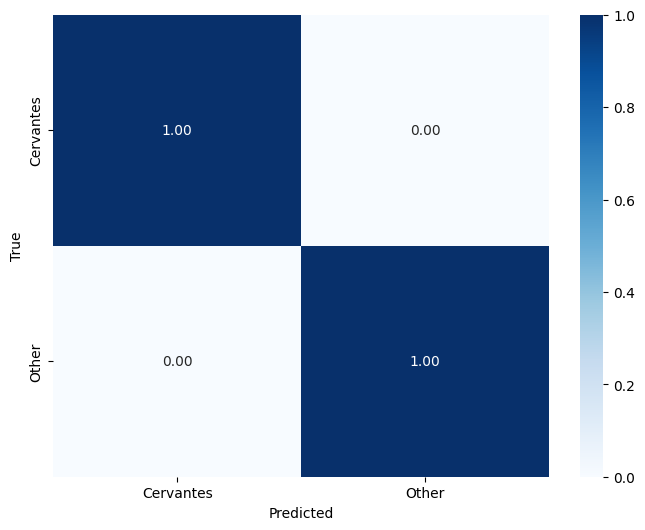

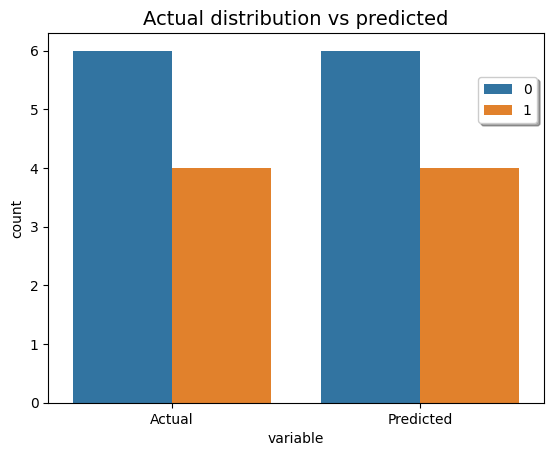

In [97]:
plot_res(y_test,y_pred)

In [98]:
y_pred_frag = get_scores(clf, X_test_frag, y_test_frag)

Accuracy on whole docs 0.9068702290076336
F1 on whole docs 0.9054444130320153

              precision    recall  f1-score   support

           0       0.94      0.95      0.94       535
           1       0.77      0.71      0.74       120

    accuracy                           0.91       655
   macro avg       0.85      0.83      0.84       655
weighted avg       0.90      0.91      0.91       655



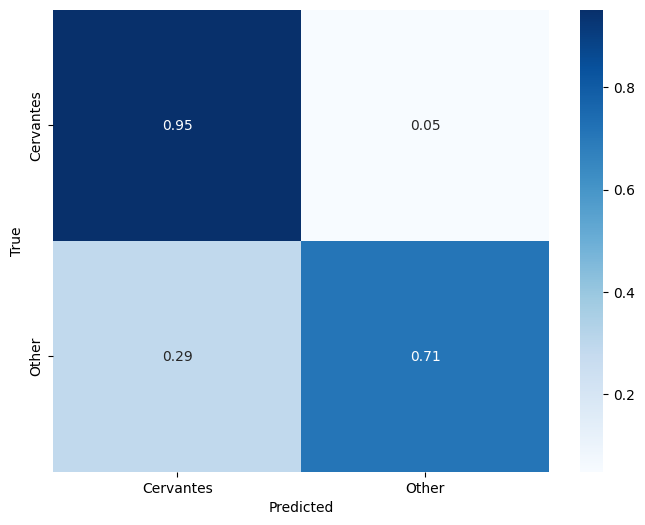

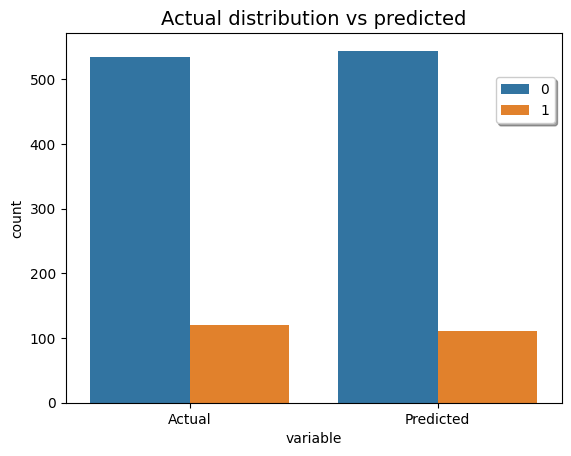

In [99]:
plot_res(y_test_frag, y_pred_frag)

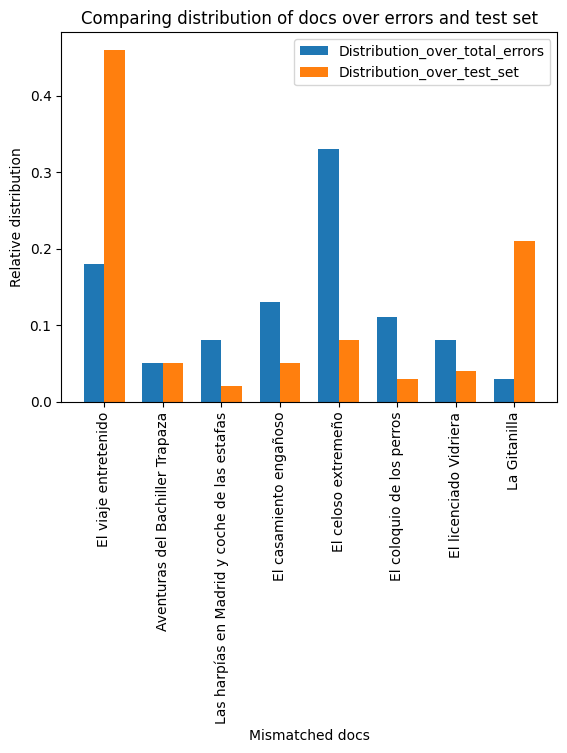

,Mismatched_doc,Distribution_over_total_errors,Distribution_over_test_set
4,Cervantes - El celoso extremeño,0.33,0.08
0,Agustín de Rojas Villandrando - El viaje entre...,0.18,0.46
3,Cervantes - El casamiento engañoso,0.13,0.05
5,Cervantes - El coloquio de los perros,0.11,0.03
2,Alonso de Castillo Solórzano - Las harpías en ...,0.08,0.02
6,Cervantes - El licenciado Vidriera,0.08,0.04
1,Alonso de Castillo Solórzano - Aventuras del B...,0.05,0.05
7,Cervantes - La Gitanilla,0.03,0.21


In [100]:
mismatched_docs, mismatched_docs_distribution, res_df = find_mismatched_docs(y_test_frag,
                                                                              y_pred_frag, 
                                                                              goups_names_test_frag, 
                                                                              groups_names_distribution_test_frag)
res_df

### With normalization

In [102]:
systems

[Pipeline(steps=[('feat_extractor',
                  <features.FeaturesFunctionWords object at 0x7f6bf7b8f220>),
                 ('classifier',
                  StandardizedCalibratedClassifierCV(base_estimator=LinearSVC(class_weight='balanced',
                                                                              dual='auto',
                                                                              max_iter=100000,
                                                                              random_state=42)))]),
 Pipeline(steps=[('feat_extractor',
                  <features.FeaturesMendenhall object at 0x7f6b43e93be0>),
                 ('classifier',
                  StandardizedCalibratedClassifierCV(base_estimator=LinearSVC(class_weight='balanced',
                                                                              dual='auto',
                                                                              max_iter=100000,
                                 

In [101]:
base_clfs = [LinearSVC(random_state=42, class_weight='balanced', max_iter=100000, dual='auto') for i in range(5)]
final_estimator = SVC(class_weight='balanced', random_state=42)
#svm = CalibratedClassifierCV(LinearSVC())


systems = [Pipeline([
    ('feat_extractor', vectorizer),
    ('classifier', StandardizedCalibratedClassifierCV(base_clf))
    ]) 
    for vectorizer, base_clf in zip(vectorizers, base_clfs)]

estimators = [(f'model{i+1}', system) for i,system in enumerate(systems)]

stack = StackingClassifier(
    estimators = estimators,
    final_estimator = final_estimator,
    cv=5,
    stack_method='predict_proba',
    n_jobs=5,
)

param_grid = {'model1__classifier__base_estimator__C': [10]}


param_grid_ = [
   {
    'kernel': ['rbf',],
    'C' : [0.01, 0.1, 1, 10, 100],
    'gamma' : [0.001, 0.1, 1, 'scale', 'auto']
},
{
    'kernel' : ['poly'],
    'C' : [0.01, 0.1, 1, 10, 100],
    'gamma' : [0.001, 0.1, 1, 'scale', 'auto'],
    'degree': [1, 2, 3, 4, 5]
}]


grid = GridSearchCV(estimator=stack, param_grid=param_grid, cv=3, n_jobs=3, scoring='f1_weighted', verbose=True)
grid.fit(X_dev, y_dev, groups=groups_dev)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/martinaleo/.local/lib/python3.10/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'es_core_news_sm' (3.1.0) was trained with spaCy v3.1.0 and may not be 100% compatible with the current version (3.7.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
/home/martinaleo/.local/lib/python3.10/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'es_core_news_sm' (3.1.0) was trained with spaCy v3.1.0 and may not be 100% compatible with the current version (3.7.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
/home/martinaleo/.local/lib/python3.10/site-packages/spacy/util.py:910: UserWarning: [W095] Mo

GridSearchCV(cv=3,
             estimator=StackingClassifier(cv=5,
                                          estimators=[('model1',
                                                       Pipeline(steps=[('feat_extractor',
                                                                        <features.FeaturesFunctionWords object at 0x7f6bf7b8f220>),
                                                                       ('classifier',
                                                                        StandardizedCalibratedClassifierCV(base_estimator=LinearSVC(class_weight='balanced',
                                                                                                                                    dual='auto',
                                                                                                                                    max_iter=100000,
                                                                                                                                    random_state=42)))])),
                                                      ('model2',
                                                       Pipeline(steps=[('feat_extra...
                                                                       ('classifier',
                                                                        StandardizedCalibratedClassifierCV(base_estimator=LinearSVC(class_weight='balanced',
                                                                                                                                    dual='auto',
                                                                                                                                    max_iter=100000,
                                                                                                                                    random_state=42)))]))],
                                          final_estimator=SVC(class_weight='balanced',
                                                              random_state=42),
                                          n_jobs=5,
                                          stack_method='predict_proba'),
             n_jobs=3,
             param_grid={'model1__classifier__base_estimator__C': [10]},
             scoring='f1_weighted', verbose=True)

In [103]:
clf=grid.best_estimator_
y_pred = get_scores(clf, X_test, y_test)

Accuracy on whole docs 1.0
F1 on whole docs 1.0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



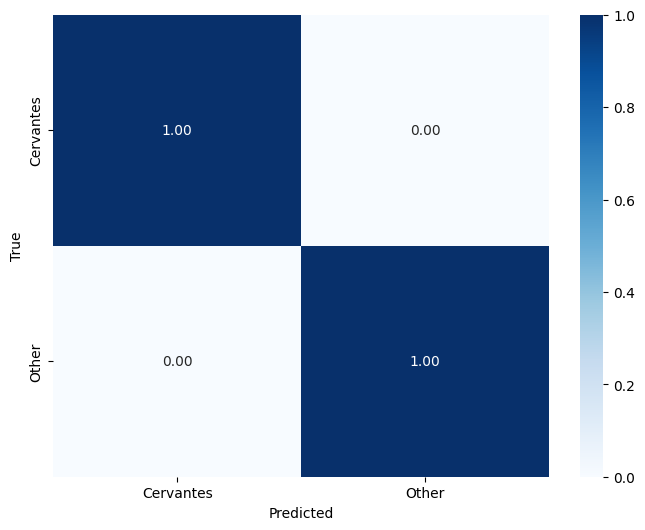

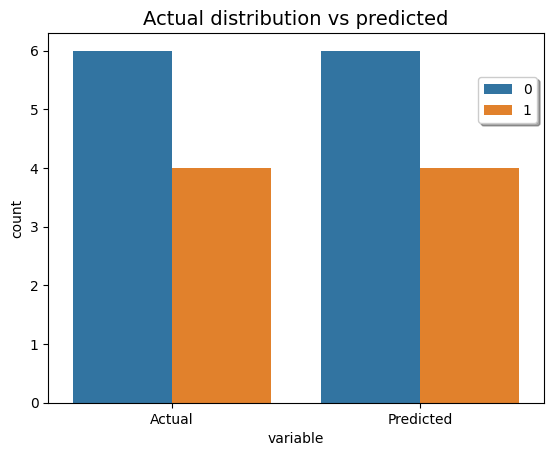

In [104]:
plot_res(y_test, y_pred)

In [105]:
y_pred_frag = get_scores(clf, X_test_frag, y_test_frag)

Accuracy on whole docs 0.815267175572519
F1 on whole docs 0.8310096947856108

              precision    recall  f1-score   support

           0       0.96      0.81      0.88       535
           1       0.50      0.83      0.62       120

    accuracy                           0.82       655
   macro avg       0.73      0.82      0.75       655
weighted avg       0.87      0.82      0.83       655



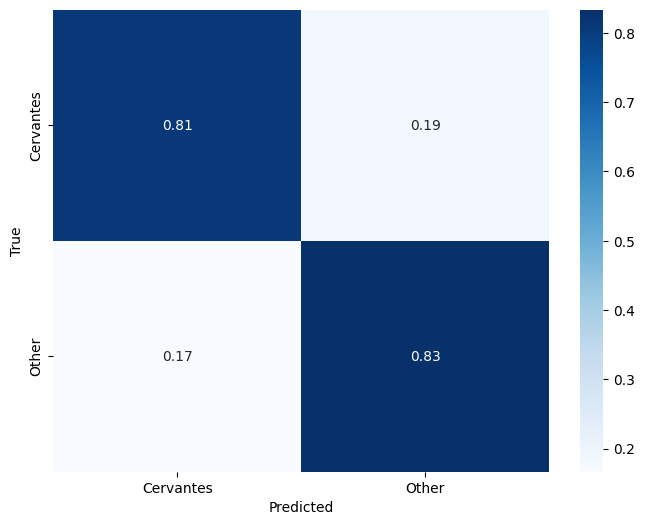

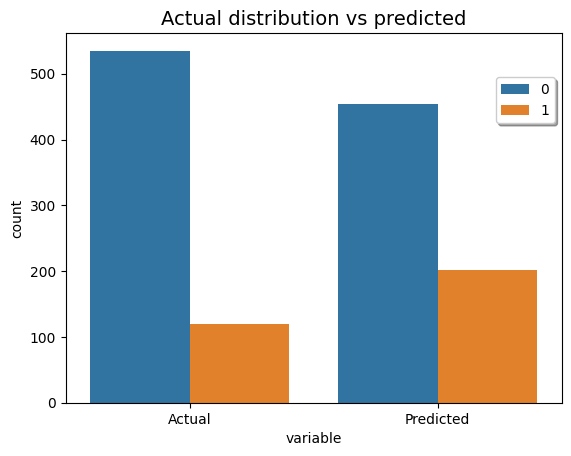

In [106]:
plot_res(y_test_frag, y_pred_frag)

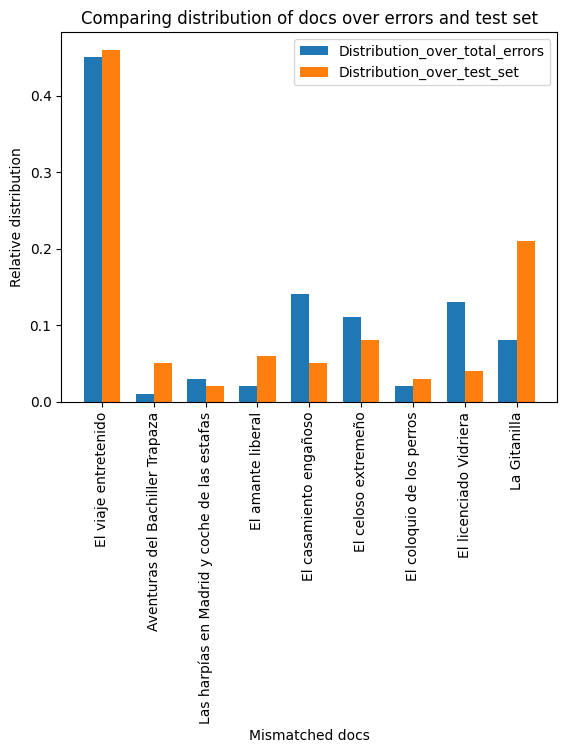

,Mismatched_doc,Distribution_over_total_errors,Distribution_over_test_set
0,Agustín de Rojas Villandrando - El viaje entre...,0.45,0.46
4,Cervantes - El casamiento engañoso,0.14,0.05
7,Cervantes - El licenciado Vidriera,0.13,0.04
5,Cervantes - El celoso extremeño,0.11,0.08
8,Cervantes - La Gitanilla,0.08,0.21
2,Alonso de Castillo Solórzano - Las harpías en ...,0.03,0.02
3,Cervantes - El amante liberal,0.02,0.06
6,Cervantes - El coloquio de los perros,0.02,0.03
1,Alonso de Castillo Solórzano - Aventuras del B...,0.01,0.05


In [107]:
mismatched_docs, mismatched_docs_distribution, res_df = find_mismatched_docs(y_test_frag,
                                                                              y_pred_frag, 
                                                                              goups_names_test_frag, 
                                                                              groups_names_distribution_test_frag)
res_df

# Ensemble

In [108]:
from sklearn.ensemble import VotingClassifier

## Majority voting

In [109]:
%%time
base_clfs = [LinearSVC(random_state=42, class_weight='balanced', max_iter=10000, dual='auto') for i in range(len(vectorizers))]
# final_estimator = SVC(class_weight='balanced', random_state=42)
# svm = CalibratedClassifierCV(LinearSVC())


systems = [Pipeline([
    ('feat_extractor', vectorizer),
    ('classifier', base_clf)
    ]) 
    for vectorizer, base_clf in zip(vectorizers, base_clfs)]

estimators = [(f'model_{i+1}', system) for i,system in enumerate(systems)]

param_grid = {'model_1__classifier__C': [10]}

vclf = VotingClassifier(
    estimators = estimators,
    n_jobs=5,
    verbose=True
)
grid = GridSearchCV(estimator=vclf,
                    param_grid=param_grid,
                    cv=3,
                    scoring='f1_weighted',
                    n_jobs=3)

grid.fit(X_dev, y_dev, groups=groups_dev)

/home/martinaleo/.local/lib/python3.10/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'es_core_news_sm' (3.1.0) was trained with spaCy v3.1.0 and may not be 100% compatible with the current version (3.7.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
/home/martinaleo/.local/lib/python3.10/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'es_core_news_sm' (3.1.0) was trained with spaCy v3.1.0 and may not be 100% compatible with the current version (3.7.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
/home/martinaleo/.local/lib/python3.10/site-packages/spacy/util.py:910: UserWarning: [W095] Mo

[Voting] .................. (1 of 5) Processing model_1, total=   1.9s
[Voting] .................. (1 of 5) Processing model_1, total=   5.8s
[Voting] .................. (1 of 5) Processing model_1, total=   8.2s
[Voting] .................. (5 of 5) Processing model_5, total=  11.8s
[Voting] .................. (5 of 5) Processing model_5, total=  31.1s
[Voting] .................. (5 of 5) Processing model_5, total=  30.9s
[Voting] .................. (3 of 5) Processing model_3, total=  36.1s
[Voting] .................. (2 of 5) Processing model_2, total=  37.2s
[Voting] .................. (4 of 5) Processing model_4, total=  40.2s
[Voting] .................. (2 of 5) Processing model_2, total= 1.1min
[Voting] .................. (2 of 5) Processing model_2, total= 1.1min
[Voting] .................. (3 of 5) Processing model_3, total= 1.1min
[Voting] .................. (3 of 5) Processing model_3, total= 1.1min
[Voting] .................. (4 of 5) Processing model_4, total= 1.2min
[Votin

/home/martinaleo/.local/lib/python3.10/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'es_core_news_sm' (3.1.0) was trained with spaCy v3.1.0 and may not be 100% compatible with the current version (3.7.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
/home/martinaleo/.local/lib/python3.10/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'es_core_news_sm' (3.1.0) was trained with spaCy v3.1.0 and may not be 100% compatible with the current version (3.7.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
/home/martinaleo/.local/lib/python3.10/site-packages/spacy/util.py:910: UserWarning: [W095] Mo

[Voting] .................. (1 of 5) Processing model_1, total=   1.3s
[Voting] .................. (5 of 5) Processing model_5, total=   4.8s
[Voting] .................. (2 of 5) Processing model_2, total=  15.0s
[Voting] .................. (4 of 5) Processing model_4, total=  18.6s
[Voting] .................. (3 of 5) Processing model_3, total=  20.3s
CPU times: user 36.1 s, sys: 1.92 s, total: 38 s
Wall time: 2min 28s


GridSearchCV(cv=3,
             estimator=VotingClassifier(estimators=[('model_1',
                                                     Pipeline(steps=[('feat_extractor',
                                                                      <features.FeaturesFunctionWords object at 0x7f6bf7b8f220>),
                                                                     ('classifier',
                                                                      LinearSVC(class_weight='balanced',
                                                                                dual='auto',
                                                                                max_iter=10000,
                                                                                random_state=42))])),
                                                    ('model_2',
                                                     Pipeline(steps=[('feat_extractor',
                                                                      <features.FeaturesMendenhall object at 0x7f6b43e93be0>...
                                                                      LinearSVC(class_weight='balanced',
                                                                                dual='auto',
                                                                                max_iter=10000,
                                                                                random_state=42))])),
                                                    ('model_5',
                                                     Pipeline(steps=[('feat_extractor',
                                                                      <features.FeaturesPOST object at 0x7f6b4419ea40>),
                                                                     ('classifier',
                                                                      LinearSVC(class_weight='balanced',
                                                                                dual='auto',
                                                                                max_iter=10000,
                                                                                random_state=42))]))],
                                        n_jobs=5, verbose=True),
             n_jobs=3, param_grid={'model_1__classifier__C': [10]},
             scoring='f1_weighted')

In [110]:
clf=grid.best_estimator_
y_pred = get_scores(clf, X_test, y_test)

Accuracy on whole docs 1.0
F1 on whole docs 1.0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



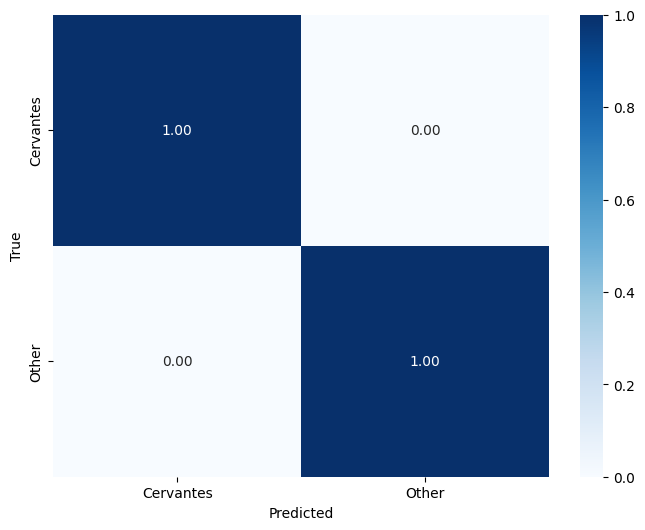

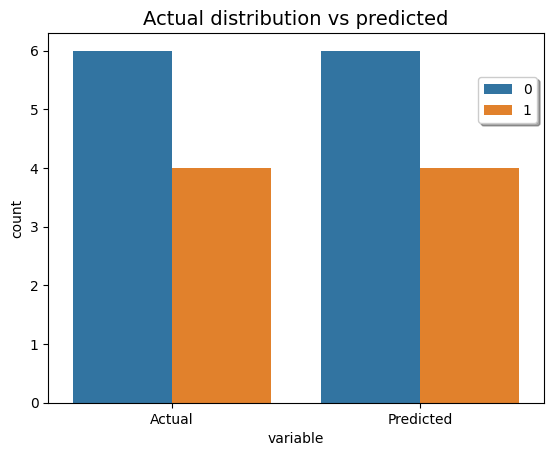

In [111]:
plot_res(y_test, y_pred)

In [112]:
y_pred_frag = get_scores(clf, X_test_frag, y_test_frag)

Accuracy on whole docs 0.8732824427480916
F1 on whole docs 0.8757587851228434

              precision    recall  f1-score   support

           0       0.93      0.91      0.92       535
           1       0.64      0.71      0.67       120

    accuracy                           0.87       655
   macro avg       0.79      0.81      0.80       655
weighted avg       0.88      0.87      0.88       655



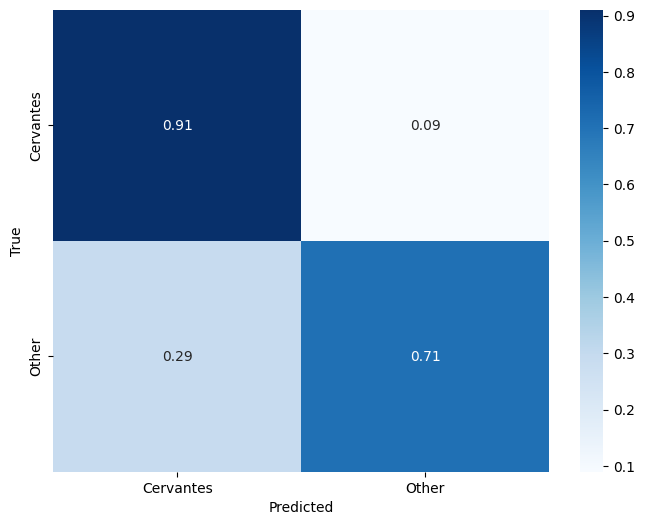

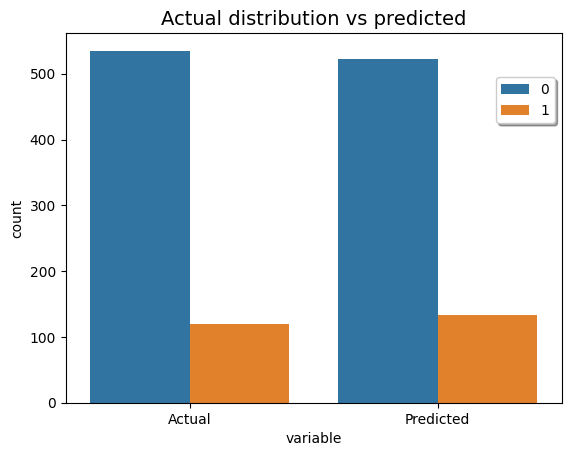

In [113]:
plot_res(y_test_frag, y_pred_frag)

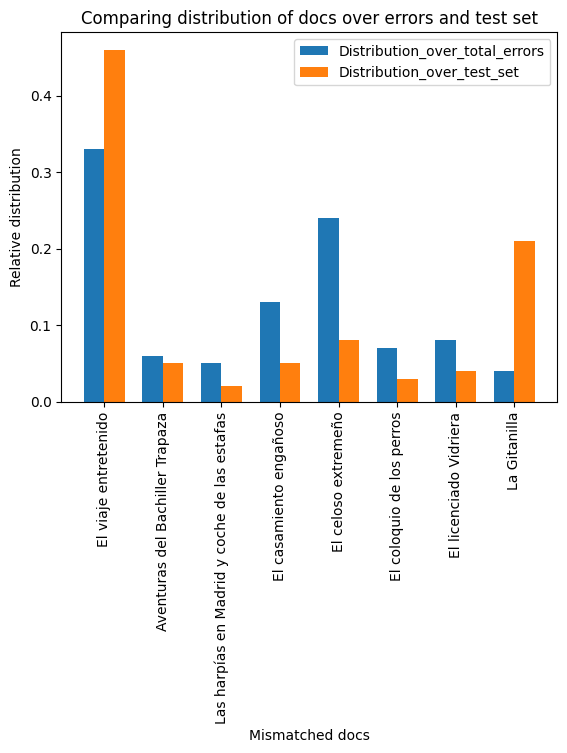

,Mismatched_doc,Distribution_over_total_errors,Distribution_over_test_set
0,Agustín de Rojas Villandrando - El viaje entre...,0.33,0.46
4,Cervantes - El celoso extremeño,0.24,0.08
3,Cervantes - El casamiento engañoso,0.13,0.05
6,Cervantes - El licenciado Vidriera,0.08,0.04
5,Cervantes - El coloquio de los perros,0.07,0.03
1,Alonso de Castillo Solórzano - Aventuras del B...,0.06,0.05
2,Alonso de Castillo Solórzano - Las harpías en ...,0.05,0.02
7,Cervantes - La Gitanilla,0.04,0.21


In [114]:
mismatched_docs, mismatched_docs_distribution, res_df = find_mismatched_docs(y_test_frag,
                                                                              y_pred_frag, 
                                                                              goups_names_test_frag, 
                                                                              groups_names_distribution_test_frag)
res_df

## Soft voting

In [115]:
%%time
base_clfs = [LinearSVC(random_state=42, class_weight='balanced', max_iter=10000, dual='auto') for i in range(len(vectorizers))]


systems = [Pipeline([
    ('feat_extractor', vectorizer),
    ('classifier', StandardizedCalibratedClassifierCV(base_clf)),
    #('z-transform', StandardScaler())
    ]) 
    for vectorizer, base_clf in zip(vectorizers, base_clfs)]

estimators = [(f'model_{i+1}', system) for i,system in enumerate(systems)]

param_grid = {'model_1__classifier__base_estimator__C': [10]}

vclf = VotingClassifier(
    estimators = estimators,
    voting='soft',
    n_jobs=5,
    verbose=True
)
grid = GridSearchCV(estimator=vclf,
                    param_grid=param_grid,
                    cv=3,
                    scoring='f1_weighted',
                    n_jobs=3)

grid.fit(X_dev, y_dev, groups=groups_dev)

/home/martinaleo/.local/lib/python3.10/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'es_core_news_sm' (3.1.0) was trained with spaCy v3.1.0 and may not be 100% compatible with the current version (3.7.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
/home/martinaleo/.local/lib/python3.10/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'es_core_news_sm' (3.1.0) was trained with spaCy v3.1.0 and may not be 100% compatible with the current version (3.7.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
/home/martinaleo/.local/lib/python3.10/site-packages/spacy/util.py:910: UserWarning: [W095] Mo

[Voting] .................. (1 of 5) Processing model_1, total=   4.5s


/home/martinaleo/.local/lib/python3.10/site-packages/sklearn/calibration.py:300: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/martinaleo/.local/lib/python3.10/site-packages/sklearn/calibration.py:300: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[Voting] .................. (1 of 5) Processing model_1, total=   8.8s


/home/martinaleo/.local/lib/python3.10/site-packages/sklearn/calibration.py:300: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[Voting] .................. (5 of 5) Processing model_5, total=  12.1s
[Voting] .................. (1 of 5) Processing model_1, total=  10.5s


/home/martinaleo/.local/lib/python3.10/site-packages/sklearn/calibration.py:300: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[Voting] .................. (5 of 5) Processing model_5, total=  33.4s


/home/martinaleo/.local/lib/python3.10/site-packages/sklearn/calibration.py:300: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[Voting] .................. (5 of 5) Processing model_5, total=  34.2s


/home/martinaleo/.local/lib/python3.10/site-packages/sklearn/calibration.py:300: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[Voting] .................. (3 of 5) Processing model_3, total=  37.4s


/home/martinaleo/.local/lib/python3.10/site-packages/sklearn/calibration.py:300: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[Voting] .................. (2 of 5) Processing model_2, total=  38.4s


/home/martinaleo/.local/lib/python3.10/site-packages/sklearn/calibration.py:300: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[Voting] .................. (4 of 5) Processing model_4, total=  42.7s


/home/martinaleo/.local/lib/python3.10/site-packages/sklearn/calibration.py:300: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[Voting] .................. (2 of 5) Processing model_2, total= 1.1min


/home/martinaleo/.local/lib/python3.10/site-packages/sklearn/calibration.py:300: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[Voting] .................. (3 of 5) Processing model_3, total= 1.1min


/home/martinaleo/.local/lib/python3.10/site-packages/sklearn/calibration.py:300: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/martinaleo/.local/lib/python3.10/site-packages/sklearn/calibration.py:300: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[Voting] .................. (2 of 5) Processing model_2, total= 1.1min
[Voting] .................. (3 of 5) Processing model_3, total= 1.1min


/home/martinaleo/.local/lib/python3.10/site-packages/sklearn/calibration.py:300: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/martinaleo/.local/lib/python3.10/site-packages/sklearn/calibration.py:300: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[Voting] .................. (4 of 5) Processing model_4, total= 1.2min
[Voting] .................. (4 of 5) Processing model_4, total= 1.2min


/home/martinaleo/.local/lib/python3.10/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'es_core_news_sm' (3.1.0) was trained with spaCy v3.1.0 and may not be 100% compatible with the current version (3.7.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
/home/martinaleo/.local/lib/python3.10/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'es_core_news_sm' (3.1.0) was trained with spaCy v3.1.0 and may not be 100% compatible with the current version (3.7.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
/home/martinaleo/.local/lib/python3.10/site-packages/spacy/util.py:910: UserWarning: [W095] Mo

[Voting] .................. (1 of 5) Processing model_1, total=   1.4s


/home/martinaleo/.local/lib/python3.10/site-packages/sklearn/calibration.py:300: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[Voting] .................. (5 of 5) Processing model_5, total=   4.8s


/home/martinaleo/.local/lib/python3.10/site-packages/sklearn/calibration.py:300: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[Voting] .................. (2 of 5) Processing model_2, total=  15.1s


/home/martinaleo/.local/lib/python3.10/site-packages/sklearn/calibration.py:300: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/martinaleo/.local/lib/python3.10/site-packages/sklearn/calibration.py:300: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[Voting] .................. (3 of 5) Processing model_3, total=  20.4s
[Voting] .................. (4 of 5) Processing model_4, total=  21.9s
CPU times: user 36.6 s, sys: 1.95 s, total: 38.6 s
Wall time: 2min 34s


GridSearchCV(cv=3,
             estimator=VotingClassifier(estimators=[('model_1',
                                                     Pipeline(steps=[('feat_extractor',
                                                                      <features.FeaturesFunctionWords object at 0x7f6bf7b8f220>),
                                                                     ('classifier',
                                                                      StandardizedCalibratedClassifierCV(base_estimator=LinearSVC(class_weight='balanced',
                                                                                                                                  dual='auto',
                                                                                                                                  max_iter=10000,
                                                                                                                                  random_state=42)))])),
                                                    ('model_2',
                                                     Pipeline(steps=[('feat_extractor',...
                                                     Pipeline(steps=[('feat_extractor',
                                                                      <features.FeaturesPOST object at 0x7f6b4419ea40>),
                                                                     ('classifier',
                                                                      StandardizedCalibratedClassifierCV(base_estimator=LinearSVC(class_weight='balanced',
                                                                                                                                  dual='auto',
                                                                                                                                  max_iter=10000,
                                                                                                                                  random_state=42)))]))],
                                        n_jobs=5, verbose=True, voting='soft'),
             n_jobs=3,
             param_grid={'model_1__classifier__base_estimator__C': [10]},
             scoring='f1_weighted')

In [116]:
clf=grid.best_estimator_
y_pred = get_scores(clf, X_test, y_test)

Accuracy on whole docs 1.0
F1 on whole docs 1.0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



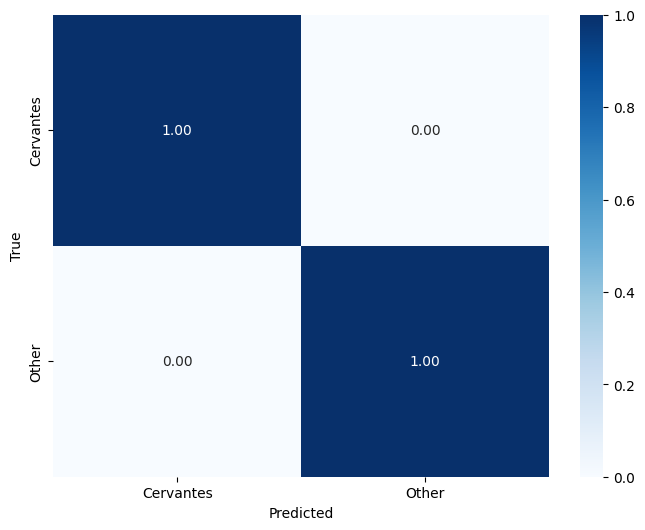

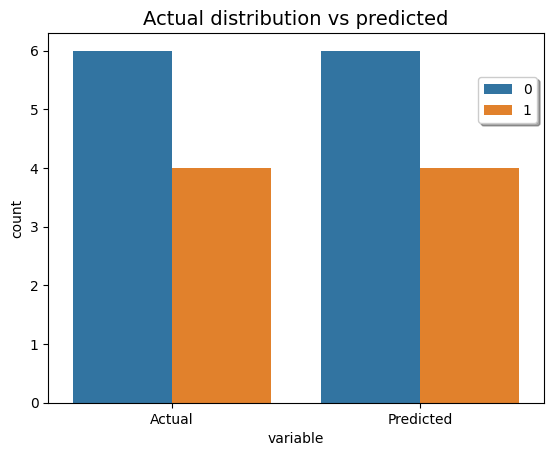

In [117]:
plot_res(y_test, y_pred)

In [118]:
y_pred_frag = get_scores(clf, X_test_frag, y_test_frag)

Accuracy on whole docs 0.76793893129771
F1 on whole docs 0.7927826656284835

              precision    recall  f1-score   support

           0       0.98      0.73      0.84       535
           1       0.44      0.92      0.59       120

    accuracy                           0.77       655
   macro avg       0.71      0.83      0.71       655
weighted avg       0.88      0.77      0.79       655



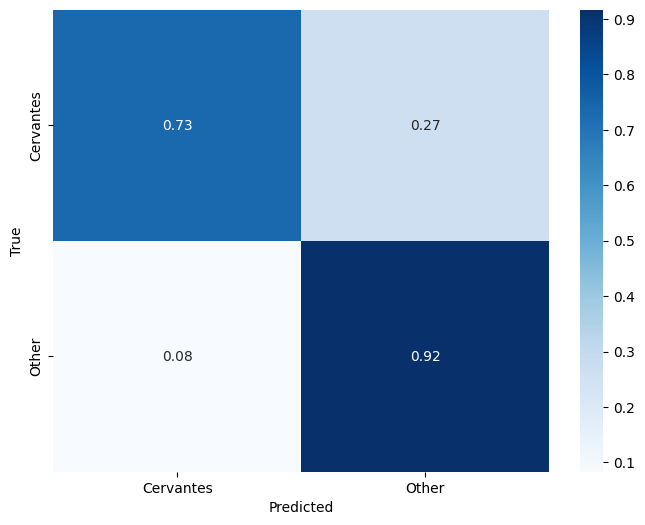

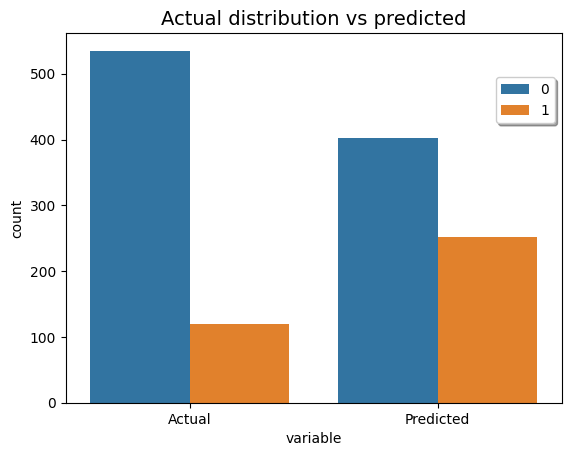

In [119]:
plot_res(y_test_frag, y_pred_frag)

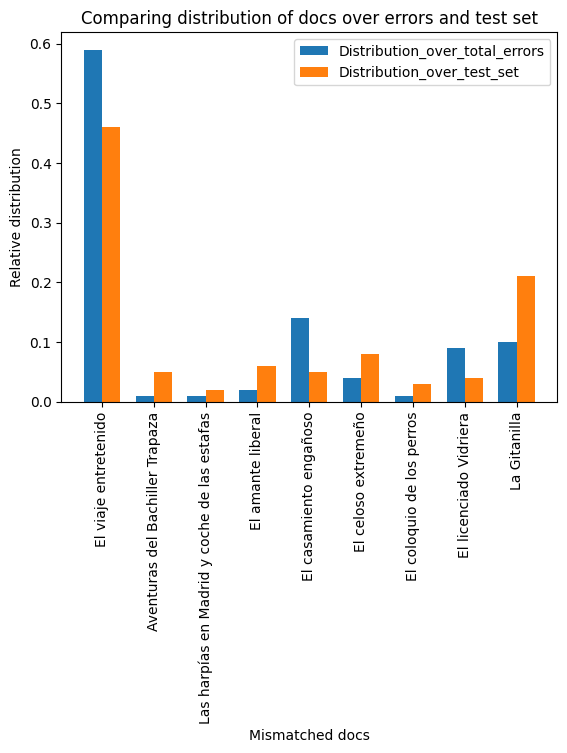

,Mismatched_doc,Distribution_over_total_errors,Distribution_over_test_set
0,Agustín de Rojas Villandrando - El viaje entre...,0.59,0.46
4,Cervantes - El casamiento engañoso,0.14,0.05
8,Cervantes - La Gitanilla,0.10,0.21
7,Cervantes - El licenciado Vidriera,0.09,0.04
5,Cervantes - El celoso extremeño,0.04,0.08
3,Cervantes - El amante liberal,0.02,0.06
1,Alonso de Castillo Solórzano - Aventuras del B...,0.01,0.05
2,Alonso de Castillo Solórzano - Las harpías en ...,0.01,0.02
6,Cervantes - El coloquio de los perros,0.01,0.03


In [120]:
mismatched_docs, mismatched_docs_distribution, res_df = find_mismatched_docs(y_test_frag,
                                                                              y_pred_frag, 
                                                                              goups_names_test_frag, 
                                                                              groups_names_distribution_test_frag)
res_df

# Classification with one classifier

In [121]:
%%time
fw_reductor = FeatureSetReductor(function_words_extractor) 
fw_red = fw_reductor.fit_transform(X_dev, authors=y_dev)
fw_red_test = fw_reductor.transform(X_test)

sl_reductor = FeatureSetReductor(sentence_len_extractor) 
sl_red = sl_reductor.fit_transform(documents=X_dev, authors=y_dev)
sl_red_test = sl_reductor.transform(X_test)

me_reductor = FeatureSetReductor(mendenhall_extractor)
me_red = me_reductor.fit_transform(X_dev, authors=y_dev)
me_red_test = me_reductor.transform(X_test)

wm_reductor = FeatureSetReductor(words_masker)
wm_red = wm_reductor.fit_transform(X_dev, authors=y_dev)
wm_red_test = wm_reductor.transform(X_test)

pos_reductor = FeatureSetReductor(POS_extractor)
pos_red = pos_reductor.fit_transform(X_dev, authors=y_dev)
pos_red_test = pos_reductor.transform(X_test)


FeatureSetReductor for FeaturesFunctionWords
features in: 313 k: 156

FeatureSetReductor for FeaturesSentenceLength
features in: 998 k: 499

FeatureSetReductor for FeaturesMendenhall
features in: 18 k: 18

FeatureSetReductor for FeaturesDVEX
features in: 406 k: 203

FeatureSetReductor for FeaturesPOST
features in: 9 k: 9

CPU times: user 2min 6s, sys: 719 ms, total: 2min 7s
Wall time: 2min 6s


In [122]:
%%time
fw_red_test_fragments = fw_reductor.transform(X_test_frag)
sl_red_test_fragments = sl_reductor.transform(X_test_frag)
me_red_test_fragments = me_reductor.transform(X_test_frag)
wm_red_test_fragments = wm_reductor.transform(X_test_frag)
pos_red_test_fragments = pos_reductor.transform(X_test_frag)

CPU times: user 9.48 s, sys: 0 ns, total: 9.48 s
Wall time: 9.48 s


In [123]:
hstacker = HstackFeatureSet(function_words_extractor, words_masker, mendenhall_extractor, POS_extractor, sentence_len_extractor)
hstacked_features = hstacker._hstack([fw_red, me_red, wm_red, pos_red, sl_red])

hstacked_features_test = hstacker._hstack([fw_red_test, me_red_test, wm_red_test, pos_red_test, sl_red_test])

hstacked_features_test_frag = hstacker._hstack([fw_red_test_fragments, me_red_test_fragments, wm_red_test_fragments, pos_red_test_fragments, sl_red_test_fragments])

In [124]:
X_dev = hstacked_features
X_test = hstacked_features_test

In [125]:
X_test_fragments = hstacked_features_test_frag

In [126]:
clf = LinearSVC(random_state=42, dual='auto', class_weight='balanced', max_iter=10000000)
scores = cross_val_score(clf, X_dev, y_dev, cv=5, scoring='f1_weighted', groups=groups_dev)
scores.mean(), scores.std()
#(0.7462415184175024, 0.08596639814090719)

(0.8045062833072523, 0.0927527025533508)

In [127]:
clf = LinearSVC(random_state=42, dual='auto', class_weight='balanced', max_iter=10000000)
clf.fit(X_dev, y_dev)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print('Results on whole documents:') 
print('Accuracy (on whole documents):', acc) 
print('Weighted f1:',f1)
print()

y_pred_fragments = clf.predict(X_test_fragments)
acc = accuracy_score(y_test_frag, y_pred_fragments)
f1_frag = f1_score(y_test_frag, y_pred_fragments, average='weighted')
print('Results on whole fragments:') 
print('Accuracy:', acc) 
print('Weighted f1:',f1_frag)


Results on whole documents:
Accuracy (on whole documents): 1.0
Weighted f1: 1.0

Results on whole fragments:
Accuracy: 0.8931297709923665
Weighted f1: 0.8927804287945098


### whole docs

In [128]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



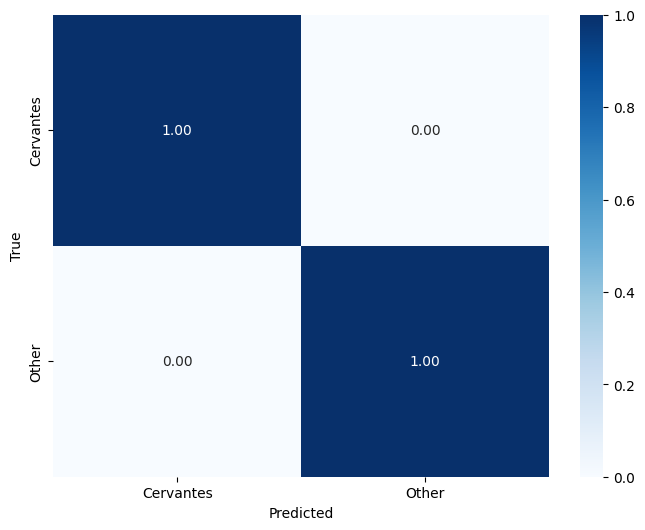

In [129]:
plt.subplots(figsize=(8,6))
cf = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cf, annot=True, fmt='.2f', cmap="Blues", xticklabels=y_labels, yticklabels=y_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

### fragmented docs

In [130]:
print(classification_report(y_test_frag, y_pred_fragments))

              precision    recall  f1-score   support

           0       0.93      0.94      0.93       535
           1       0.71      0.70      0.71       120

    accuracy                           0.89       655
   macro avg       0.82      0.82      0.82       655
weighted avg       0.89      0.89      0.89       655



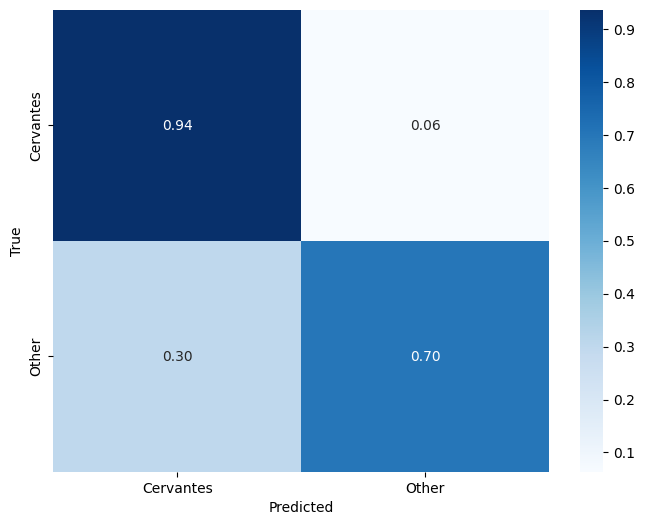

In [131]:
plt.subplots(figsize=(8,6))
cf = confusion_matrix(y_test_frag, y_pred_fragments, normalize='true')
sns.heatmap(cf, annot=True, fmt='.2f', cmap="Blues", xticklabels=y_labels, yticklabels=y_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [132]:
def find_mismatched_docs(y_test, y_pred, group_names_test, groups_names_distribution, plot_res=True):
    res_df = pd.DataFrame(columns=['Mismatched_doc', 'Distribution_over_total_errors', 'Distribution_over_test_set'])
    wrong_indices = np.where(y_test != y_pred)[0]
    mismatched_docs = [group_names_test[idx] for idx in wrong_indices]
    distribution = {name:round((np.unique(mismatched_docs, return_counts=True)[1][i])/len(mismatched_docs),2) 
                                 for i, name in enumerate(np.unique(mismatched_docs))}

    for i, (key, val) in enumerate(distribution.items()):    
        res_df.loc[i]={
            'Mismatched_doc':  key,
            'Distribution_over_total_errors': val,
            'Distribution_over_test_set':groups_names_distribution[key] 
        }

    if plot_res:
        positions = np.arange(len(res_df))
        plt.bar(positions, res_df['Distribution_over_total_errors'], 0.35, label='Distribution_over_total_errors')
        plt.bar(positions + 0.35, res_df['Distribution_over_test_set'], 0.35, label='Distribution_over_test_set')

        plt.xlabel('Mismatched docs')
        plt.ylabel('Relative distribution')
        plt.title('Comparing distribution of docs over errors and test set')
        plt.xticks(positions + 0.35 / 2, res_df['Mismatched_doc'].apply(lambda x: x.split(' - ')[1]))
        plt.xticks(rotation=90)
        plt.legend()

        plt.show()
    return mismatched_docs, distribution, res_df.sort_values(by='Distribution_over_total_errors', ascending=False)

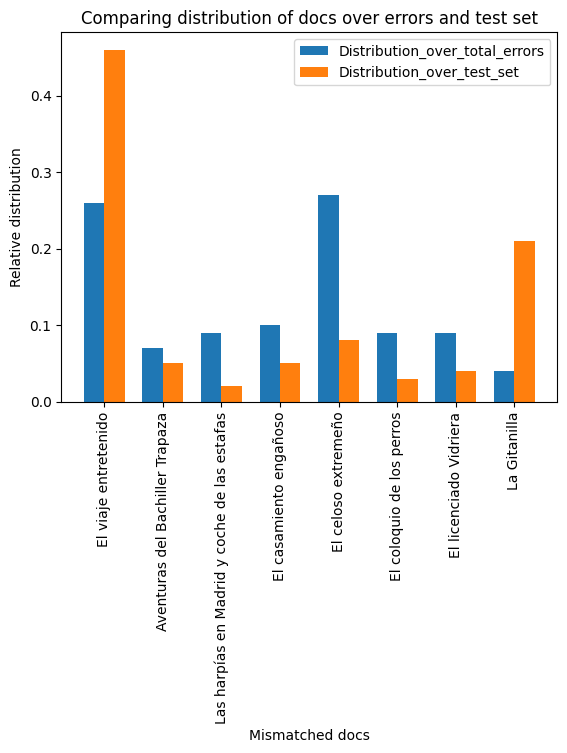

,Mismatched_doc,Distribution_over_total_errors,Distribution_over_test_set
4,Cervantes - El celoso extremeño,0.27,0.08
0,Agustín de Rojas Villandrando - El viaje entre...,0.26,0.46
3,Cervantes - El casamiento engañoso,0.10,0.05
2,Alonso de Castillo Solórzano - Las harpías en ...,0.09,0.02
5,Cervantes - El coloquio de los perros,0.09,0.03
6,Cervantes - El licenciado Vidriera,0.09,0.04
1,Alonso de Castillo Solórzano - Aventuras del B...,0.07,0.05
7,Cervantes - La Gitanilla,0.04,0.21


In [133]:
mismatched_docs, mismatched_docs_distribution, res_df=find_mismatched_docs(y_test_frag, y_pred_fragments, goups_names_test_frag, groups_names_distribution_test_frag)
res_df

## Grid search

In [134]:
clf = LinearSVC(random_state=42, dual='auto', class_weight='balanced', max_iter=10000000)   
#group_kfold = GroupKFold(n_splits=5)

param_grid= {'C': [0.1, 1, 10, 100,], #1, 10, 100, 200
             'dual': ['auto'],
             'random_state': [42]}

grid = GridSearchCV(
            clf,
            param_grid=param_grid,
            cv=5,
            n_jobs=-1,
            scoring='f1_weighted')

grid.fit(X_dev, y_dev, groups=groups_dev)
grid.best_estimator_, grid.best_score_

(LinearSVC(C=10, class_weight='balanced', dual='auto', max_iter=10000000,
           random_state=42),
 0.8145078458206365)

In [135]:
clf = grid.best_estimator_
clf.fit(X_dev, y_dev)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print('Results on whole documents:') 
print('Accuracy (on whole documents):', acc) 
print('Weighted f1:',f1)
print()

y_pred_fragments = clf.predict(X_test_fragments)
acc = accuracy_score(y_test_frag, y_pred_fragments)
f1_frag = f1_score(y_test_frag, y_pred_fragments, average='weighted')
print('Results on whole fragments:') 
print('Accuracy:', acc) 
print('Weighted f1:',f1)

Results on whole documents:
Accuracy (on whole documents): 1.0
Weighted f1: 1.0

Results on whole fragments:
Accuracy: 0.8961832061068702
Weighted f1: 1.0


### whole docs

In [136]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



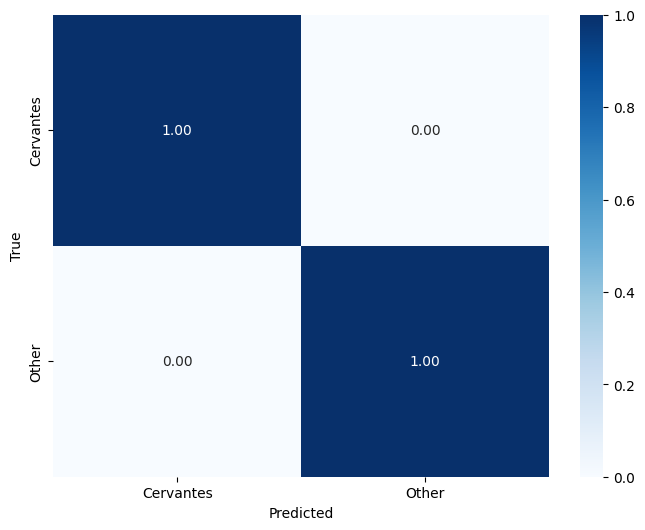

In [137]:
plt.subplots(figsize=(8,6))
cf = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cf, annot=True, fmt='.2f', cmap="Blues", xticklabels=y_labels, yticklabels=y_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

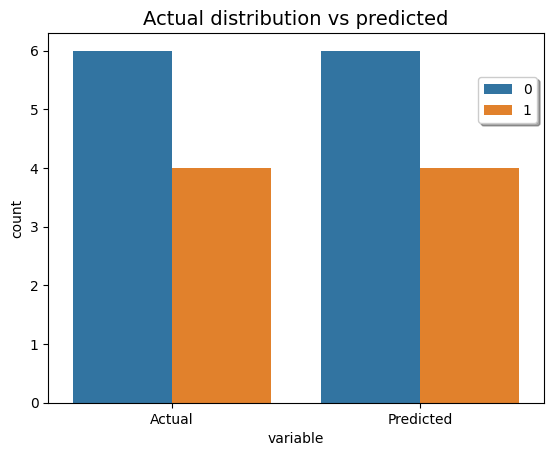

In [138]:
df_res = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
sns.countplot(x="variable", hue="value", data=pd.melt(df_res))
plt.title('Actual distribution vs predicted', fontsize=14)

plt.legend(loc='best', bbox_to_anchor=(1, 0.9), fancybox=True, shadow=True)
plt.show()

### fragmented docs

In [139]:
print(classification_report(y_test_frag, y_pred_fragments))

              precision    recall  f1-score   support

           0       0.93      0.94      0.94       535
           1       0.73      0.68      0.71       120

    accuracy                           0.90       655
   macro avg       0.83      0.81      0.82       655
weighted avg       0.89      0.90      0.89       655



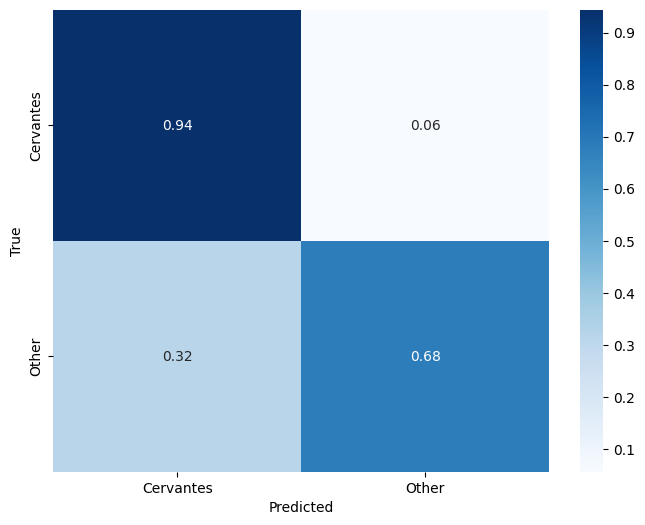

In [140]:
plt.subplots(figsize=(8,6))
cf = confusion_matrix(y_test_frag, y_pred_fragments, normalize='true')
sns.heatmap(cf, annot=True, fmt='.2f', cmap="Blues", xticklabels=y_labels, yticklabels=y_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

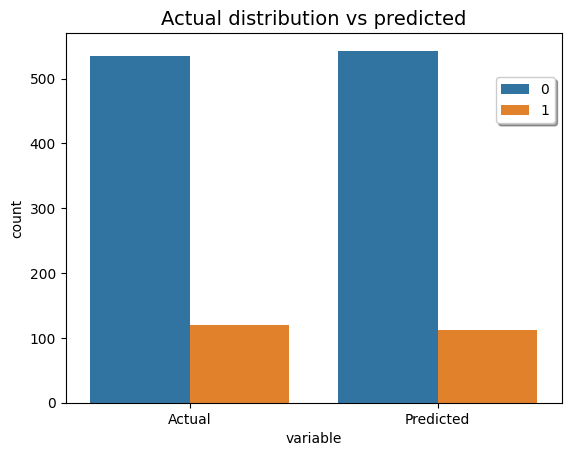

In [141]:
df_res = pd.DataFrame({'Actual': y_test_frag, 'Predicted': y_pred_fragments})
sns.countplot(x="variable", hue="value", data=pd.melt(df_res))
plt.title('Actual distribution vs predicted', fontsize=14)

plt.legend(loc='best', bbox_to_anchor=(1, 0.9), fancybox=True, shadow=True)
plt.show()

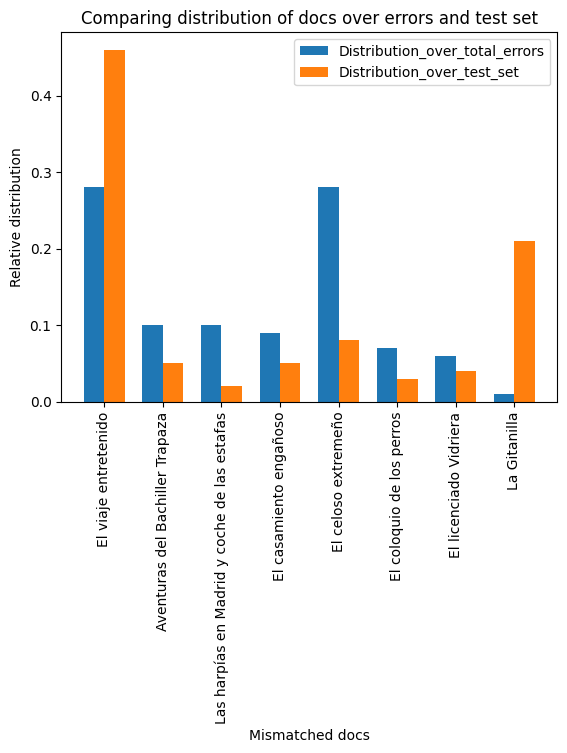

,Mismatched_doc,Distribution_over_total_errors,Distribution_over_test_set
0,Agustín de Rojas Villandrando - El viaje entre...,0.28,0.46
4,Cervantes - El celoso extremeño,0.28,0.08
1,Alonso de Castillo Solórzano - Aventuras del B...,0.10,0.05
2,Alonso de Castillo Solórzano - Las harpías en ...,0.10,0.02
3,Cervantes - El casamiento engañoso,0.09,0.05
5,Cervantes - El coloquio de los perros,0.07,0.03
6,Cervantes - El licenciado Vidriera,0.06,0.04
7,Cervantes - La Gitanilla,0.01,0.21


In [142]:
mismatched_docs, mismatched_docs_distribution, res_df=find_mismatched_docs(y_test_frag, y_pred_fragments, goups_names_test_frag, groups_names_distribution_test_frag)
res_df

## Model Evaluation

In [143]:
confidence_scores = clf.decision_function(X_test)
# print('Confidence Scores:')
# for score, pred, true in zip(confidence_scores, y_pred, y_test):
#     print(score, pred, true)

In [144]:
clf = CalibratedClassifierCV(clf) 
clf.fit(X_dev, y_dev)
y_proba = clf.predict_proba(X_test)

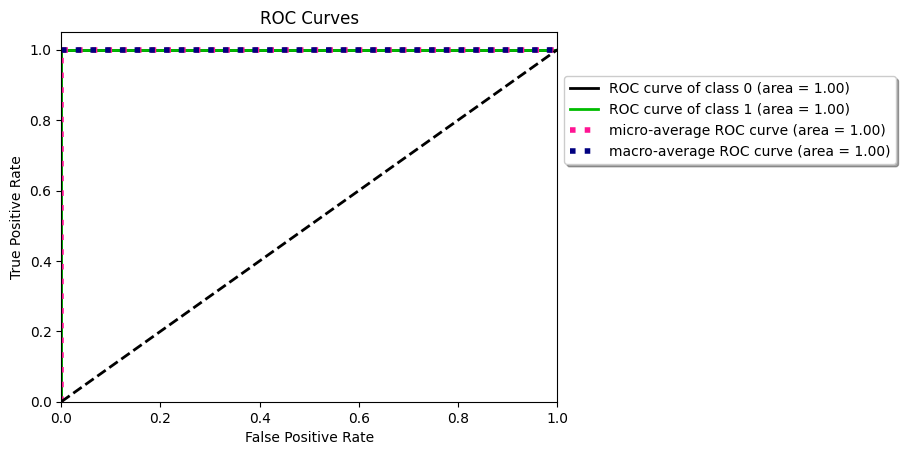

In [145]:
plot_roc(y_test, clf.predict_proba(X_test))
plt.legend(loc='best', bbox_to_anchor=(1, 0.9), fancybox=True, shadow=True)
plt.show()
#print(roc_auc_score(y_test, y_proba))

In [146]:
clf = CalibratedClassifierCV(clf) 
clf.fit(X_dev, y_dev)
y_proba = clf.predict_proba(X_test)

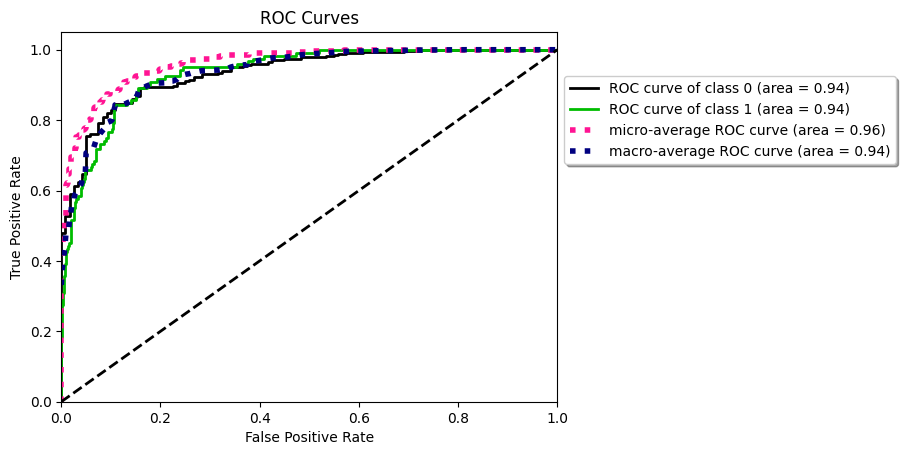

In [147]:
plot_roc(y_test_frag, clf.predict_proba(X_test_fragments))
plt.legend(loc='best', bbox_to_anchor=(1, 0.9), fancybox=True, shadow=True)
plt.show()